In [1]:
import sys, os
os.environ["CUDA_VISIBLE_DEVICES"] = "2"
# import pickle as pk
import numpy as np
import torch
dev = torch.device("cuda")
import torch.optim as optim
# from torch.distributions import MultivariateNormal
# from torch.distributions import Normal
root_dir = '/mnt/home/spandey/ceph/AR_NPE/'
os.chdir(root_dir)
# import colossus
import sys, os
# append the root_dir to the path
sys.path.append(root_dir)
from nf.combined_models import COMBINED_Model
from nf.all_models import *
from nf.utils_data_prep import *
# from tqdm import tqdm
# import pyyaml
from colossus.cosmology import cosmology
params = {'flat': True, 'H0': 67.11, 'Om0': 0.3175, 'Ob0': 0.049, 'sigma8': 0.834, 'ns': 0.9624}
cosmo = cosmology.setCosmology('myCosmo', **params)
# get halo mass function:
from colossus.lss import mass_function
from tqdm import tqdm
    
import yaml

# autoreload modules
%load_ext autoreload
%autoreload 2



In [2]:
import matplotlib
%matplotlib inline
import matplotlib.pyplot as pl


In [3]:
# run_config_name = sys.argv[1]
# run_config_name = 'run_test_128_condFPM_uniformcic_fof_lgMmin5e13_wL2norm_highknots.yaml'
run_config_name = 'run_Ntot_M1_only_128_condFPM_uniformcic_fof_lgMmin1e13_wL2norm_highknots.yaml'

with open("/mnt/home/spandey/ceph/AR_NPE/run_configs/" + run_config_name,"r") as file_object:
    config=yaml.load(file_object,Loader=yaml.SafeLoader)






In [4]:

config_sims = config['sim_settings']
ji_array = np.arange(int(config_sims['nsims']))
ns_d = config_sims['ns_d']
nb = config_sims['nb']
nax_d =  ns_d // nb
nf = config_sims['nf']
layers_types = config_sims['layers_types']
nc = 0
for jl in range(len(layers_types)):
    if layers_types[jl] == 'cnn':
        nc += 1
    elif layers_types[jl] == 'res':
        nc += 2
    else:
        raise ValueError("layer type not supported")

z_all = config_sims['z_all']
z_all_FP = config_sims['z_all_FP']
ns_h = config_sims['ns_h']
nax_h = ns_h // nb
cond_sim = config_sims['cond_sim']

nsims_per_batch = config_sims['nsims_per_batch']
nbatches_train = config_sims['nbatches_train']

mass_type = config_sims['mass_type']
lgMmin = config_sims['lgMmin']
lgMmax = config_sims['lgMmax']
stype = config_sims['stype']
rescale_sub = config_sims['rescale_sub']
lgMmincutstr = config_sims['lgMmincutstr']
subsel_highM1 = config_sims['subsel_highM1']
nsubsel = config_sims['nsubsel']
is_HR = config_sims['is_HR']

try:
    Nmax = config_sims['Nmax']
except:
    Nmax = 4

config_net = config['network_settings']
hidden_dim_MAF = config_net['hidden_dim_MAF']
learning_rate = config_net['learning_rate']
K_M1 = config_net['K_M1']
B_M1 = config_net['B_M1']
nflows_M1_NSF = config_net['nflows_M1_NSF']

K_Mdiff = config_net['K_Mdiff']
B_Mdiff = config_net['B_Mdiff']
nflows_Mdiff_NSF = config_net['nflows_Mdiff_NSF']

base_dist_Ntot = config_net['base_dist_Ntot']
if base_dist_Ntot == 'None':
    base_dist_Ntot = None
base_dist_M1 = config_net['base_dist_M1']
base_dist_Mdiff = config_net['base_dist_Mdiff']
ngauss_M1 = config_net['ngauss_M1']

changelr = config_net['changelr']
ksize = nf
nfeature_cnn = config_net['nfeature_cnn']
nout_cnn = 4 * nfeature_cnn
if cond_sim == 'fastpm':
    ninp = len(z_all_FP)
elif cond_sim == 'quijote':
    ninp = len(z_all)
else:
    raise ValueError("cond_sim not supported")

num_cond = nout_cnn + ninp





In [5]:
# is_HR
stype



'cic'

In [6]:
df_d_all_train, df_d_all_nsh_train, df_Mh_all_train, df_Nh_train, ind_subsel_train = load_density_halo_data_NGP(
    ji_array, ns_d, nb, nf, nc, z_all, ns_h,sdir='/mnt/home/spandey/ceph/Quijote/data_NGP_self',
    stype=stype, mass_type=mass_type, lgMmincutstr = lgMmincutstr, subsel_highM1=subsel_highM1, nsubsel=nsubsel, is_HR = is_HR
    )

# # Prepare the density and halo data
return_dict_train = prep_density_halo_cats_batched(
    df_d_all_train, df_d_all_nsh_train, df_Mh_all_train, df_Nh_train, nsims=nsims_per_batch,
    nbatches = nbatches_train, Mmin=lgMmin, Mmax=lgMmax, rescaleM_sub=rescale_sub, Nmax=Nmax
    )

if cond_sim == 'fastpm':
    df_d_all_train_FP, df_d_all_nsh_train_FP, df_Mh_all_train_FP, df_Nh_train_FP, ind_subsel_train_FP = load_density_halo_data_NGP(
        ji_array, ns_d, nb, nf, nc, z_all_FP, ns_h, stype=stype,sdir='/mnt/home/spandey/ceph/Quijote/data_NGP_self/fastpm', subsel_highM1=subsel_highM1, ind_subsel=ind_subsel_train
        )

    # # Prepare the density and halo data
    return_dict_train_FP = prep_density_halo_cats_batched(
        df_d_all_train_FP, df_d_all_nsh_train_FP, df_Mh_all_train_FP, df_Nh_train_FP, nsims=nsims_per_batch,
        nbatches = nbatches_train, Mmin=lgMmin, Mmax=lgMmax, rescaleM_sub=rescale_sub
        )
else:
    return_dict_train_FP = None

    

In [7]:
# len(ind_subsel_train_FP), len(ind_subsel_train)
return_dict_train.keys()
# df_d_all_train.shape
# ji_array




dict_keys(['df_d_all', 'df_d_all_nsh', 'M_halos_all_sort_norm', 'Mmin', 'Mmax', 'Nmax', 'mask_M_diff', 'mask_M1', 'M1_halos_all_norm', 'M_diff_halos_all_norm_masked', 'Nhalo_train_mg_arr', 'N_halos_all', 'mu_all', 'sig_all', 'ngauss_Nhalo'])

In [8]:
# return_dict_train['df_d_all'].shape, return_dict_train_FP['df_d_all'].shape
# return_dict_train['M_halos_all_sort_norm'].shape, return_dict_train_FP['M_halos_all_sort_norm'].shape
# return_dict_train['M_diff_halos_all_norm_masked'].shape
return_dict_train['df_d_all_nsh'][0,:,0,...].shape, return_dict_train['N_halos_all'][0,...].shape


((512, 16, 16, 16), (512, 4096))

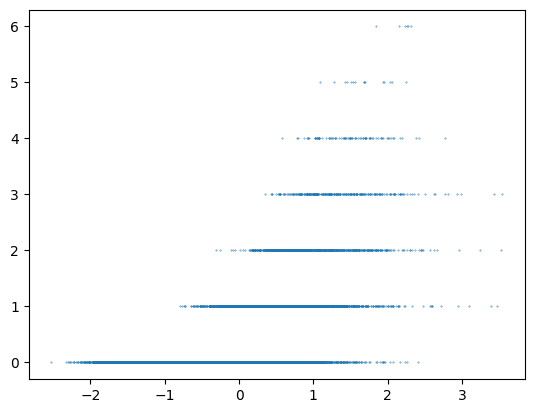

In [9]:
pl.figure()
_ = pl.scatter(return_dict_train['df_d_all_nsh'][0,:,0,...].flatten()[::100], return_dict_train['N_halos_all'][0,...].flatten()[::100], s=0.1)


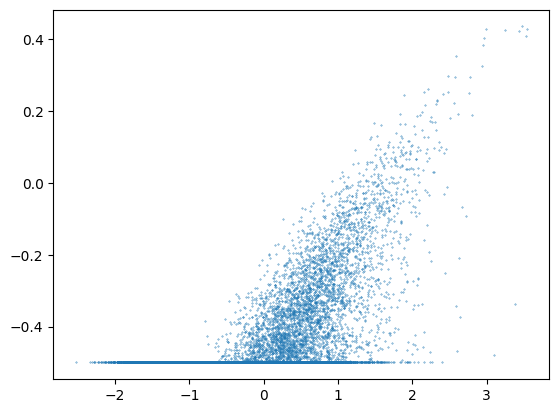

In [27]:
pl.figure()
_ = pl.scatter(return_dict_train['df_d_all_nsh'][0,:,0,...].flatten()[::100], return_dict_train['M1_halos_all_norm'][0,...].flatten()[::100], s=0.1)



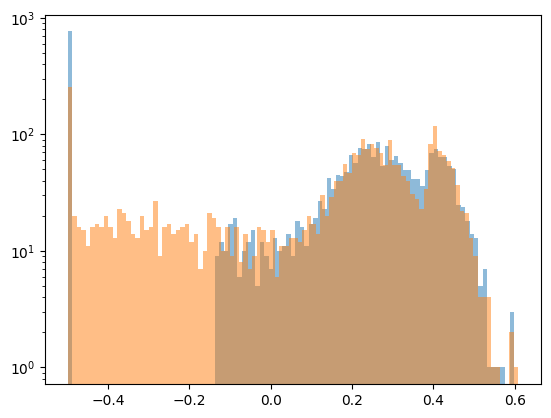

In [28]:
# lgMmin
# return_dict_train_FP['M1_halos_all_norm']
delta_all = return_dict_train['df_d_all_nsh'][0,:,0,...].reshape(512, 4096)
indsel = np.where(delta_all > 2.5)
pl.figure()
_ = pl.hist(return_dict_train_FP['M1_halos_all_norm'][0,...][indsel].flatten(), bins=100, alpha=0.5, label='FP')
_ = pl.hist(return_dict_train['M1_halos_all_norm'][0,...][indsel].flatten(), bins=100, alpha=0.5, label='PM')
pl.yscale('log')


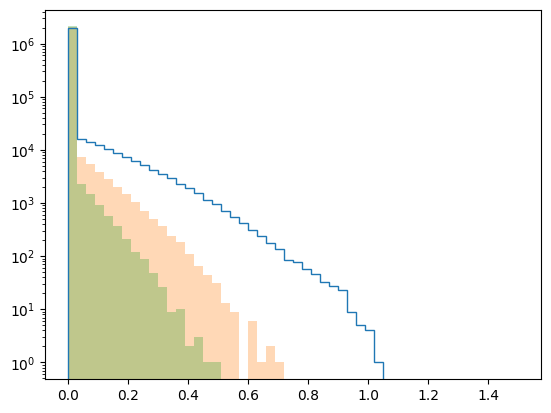

In [10]:
pl.figure()
_ = pl.hist(return_dict_train['M_diff_halos_all_norm_masked'][...,0].flatten(), bins=50, range=(0,1.5), histtype='step', label='z=0')
_ = pl.hist(return_dict_train['M_diff_halos_all_norm_masked'][...,1].flatten(), bins=50, range=(0,1.5), alpha=0.3)
_ = pl.hist(return_dict_train['M_diff_halos_all_norm_masked'][...,2].flatten(), bins=50, range=(0,1.5), alpha=0.3)
pl.yscale('log')


In [11]:
return_dict_train['df_d_all'].shape

(1, 512, 4, 24, 24, 24)

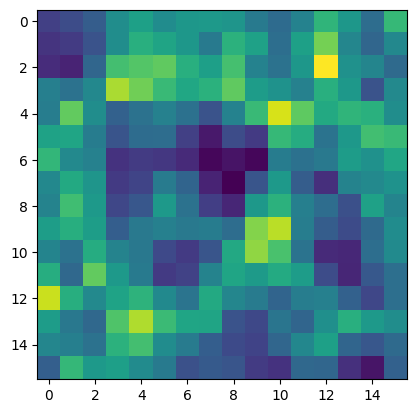

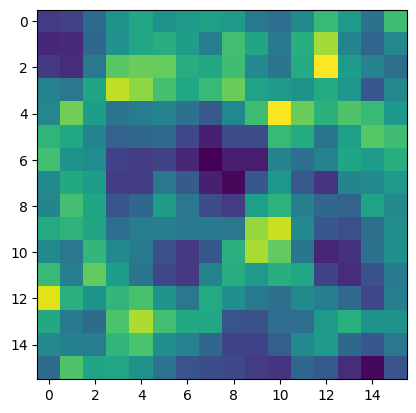

In [12]:
indp = 109

pl.figure()
pl.imshow(return_dict_train['df_d_all_nsh'][0,indp, 0, 8, :, :])
pl.figure()
pl.imshow(return_dict_train_FP['df_d_all_nsh'][0,indp, 0, 8, :, :])



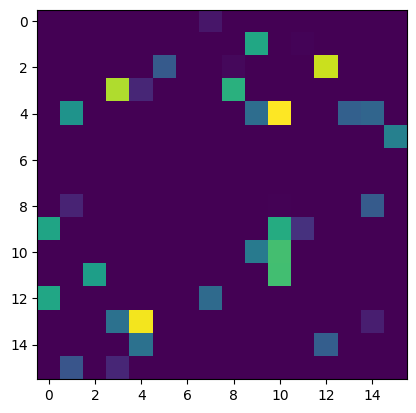

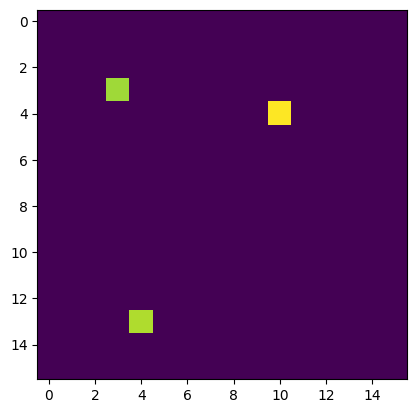

In [13]:
# indp = 10
import matplotlib
%matplotlib inline
import matplotlib.pyplot as pl
pl.figure()
pl.imshow(return_dict_train['M_halos_all_sort_norm'][0,indp,:, 0].reshape(16,16,16)[8,:,:])
pl.figure()
pl.imshow(return_dict_train_FP['M_halos_all_sort_norm'][0,indp,:,0].reshape(16,16,16)[8,:,:])



In [14]:
lgM_array = np.linspace(lgMmin, lgMmax, 1000)
M_array = 10**lgM_array
if '200c' in mass_type:
    hmf = mass_function.massFunction(M_array, 0, mdef = '200c', model = 'tinker08', q_out = 'dndlnM')
if 'vir' in mass_type:
    hmf = mass_function.massFunction(M_array, 0, mdef = 'vir', model = 'tinker08', q_out = 'dndlnM')    
if 'fof' in mass_type:
    hmf = mass_function.massFunction(M_array, 0, mdef = 'fof', model = 'bhattacharya11', q_out = 'dndlnM')
lgM_rescaled = rescale_sub + (lgM_array - lgMmin)/(lgMmax-lgMmin)

int_val = sp.integrate.simps(hmf, lgM_rescaled)
hmf_pdf = hmf/int_val
# define the cdf of the halo mass function
hmf_cdf = np.zeros_like(hmf_pdf)
for i in range(len(hmf_cdf)):
    hmf_cdf[i] = sp.integrate.simps(hmf_pdf[:i+1], lgM_rescaled[:i+1])


# num_cond_Ntot = num_cond
# model_Ntot = SumGaussModel(
#     hidden_dim=hidden_dim_MAF,
#     num_cond=num_cond_Ntot,
#     ngauss=return_dict_train['ngauss_Nhalo'],
#     mu_all=return_dict_train['mu_all'],
#     sig_all=return_dict_train['sig_all'],
#     base_dist=base_dist_Ntot   
#     )

# num_cond_M1 = num_cond + 1
# # if conditioned on fastpm we will also give the fastpm fof M1 halos and its mask as conditional
# if cond_sim == 'fastpm':
#     num_cond_M1 += 2

# model_M1 = NSF_M1_CNNcond(
#     K=K_M1,
#     B=B_M1,
#     hidden_dim=hidden_dim_MAF,
#     num_cond=num_cond_M1,
#     nflows=nflows_M1_NSF,
#     base_dist=base_dist_M1,
#     ngauss=ngauss_M1,
#     lgM_rs_tointerp=lgM_rescaled,
#     hmf_pdf_tointerp=hmf_pdf,
#     hmf_cdf_tointerp=hmf_cdf    
#     )

# ndim_diff = return_dict_train['M_diff_halos_all_norm_masked'][0].shape[2]
# num_cond_Mdiff = num_cond + 2
# model_Mdiff = NSF_Mdiff_CNNcond(
#     dim=ndim_diff,
#     K=K_Mdiff,
#     B=B_Mdiff,
#     hidden_dim=hidden_dim_MAF,
#     num_cond=num_cond_Mdiff,
#     nflows=nflows_Mdiff_NSF,
#     base_dist=base_dist_Mdiff,
#     mu_pos=True
#     )

# ndim = ndim_diff + 1
# model = COMBINED_Model(
#     None,
#     model_Mdiff,
#     # None,
#     model_M1,
#     model_Ntot,
#     ndim,
#     ksize,
#     ns_d,
#     ns_h,
#     nb,
#     ninp,
#     nfeature_cnn,
#     nout_cnn,
#     layers_types=layers_types,
#     act='tanh',
#     padding='valid',
#     sep_Ntot_cond=True,
#     sep_M1_cond=True,
#     sep_Mdiff_cond=True,
#     num_cond_Ntot = num_cond_Ntot,
#     num_cond_M1 = num_cond_M1,
#     num_cond_Mdiff = num_cond_Mdiff
#     )

# model.to(dev)

# print()


In [15]:
# base_dist_Ntot


In [16]:
from torch.utils.data import DataLoader, Dataset
# class LoadCustomData(Dataset):
#     def __init__(self, return_dict, return_dict_FP, all_gpu=False):
#         if return_dict_FP is not None:
#             self.cond_tensor = torch.Tensor(np.array(return_dict_FP['df_d_all']))
#             cond_nsh = np.moveaxis(np.array(return_dict_FP['df_d_all_nsh']), 2, 5)
#             self.cond_tensor_nsh = torch.Tensor((cond_nsh)).reshape(-1, nsims_per_batch * (nax_h ** 3), ninp)
#         else:
#             self.cond_tensor = torch.Tensor(np.array(return_dict['df_d_all']))
#             cond_nsh = np.moveaxis(np.array(return_dict['df_d_all_nsh']), 2, 5)
#             self.cond_tensor_nsh = torch.Tensor((cond_nsh)).reshape(-1, nsims_per_batch * (nax_h ** 3), ninp)

#         self.mask_tensor_M1_train = torch.Tensor(np.array(return_dict['mask_M1'])).reshape(-1, nsims_per_batch * (nax_h**3))
#         self.mask_tensor_Mdiff_train = torch.Tensor((np.array(return_dict['mask_M_diff']))).reshape(-1, nsims_per_batch * (nax_h**3), ndim_diff)

#         self.X_M1 = torch.Tensor((np.array(return_dict['M1_halos_all_norm']))).reshape(-1, nsims_per_batch * (nax_h**3), 1)
#         self.X_Nhalo = torch.Tensor(np.array(return_dict['Nhalo_train_mg_arr'])).reshape(-1, nsims_per_batch * (nax_h**3), 1)
#         self.X_Mdiff = torch.Tensor(np.array(return_dict['M_diff_halos_all_norm_masked'])).reshape(-1, nsims_per_batch * (nax_h**3),ndim_diff)
#         self.Nhalos_truth_tensor = torch.Tensor(((np.array(return_dict['N_halos_all'])))).reshape(-1, nsims_per_batch * (nax_h**3), 1)

#         if return_dict_FP is not None:
#             self.mask_tensor_M1_train_FP = torch.Tensor(np.array(return_dict_FP['mask_M1'])).reshape(-1, nsims_per_batch * (nax_h**3))
#             self.X_M1_FP = torch.Tensor((np.array(return_dict_FP['M1_halos_all_norm']))).reshape(-1, nsims_per_batch * (nax_h**3), 1)
#         else:
#             self.mask_tensor_M1_train_FP = None
#             self.X_M1_FP = None
#         if all_gpu:
            # self.cond_tensor = self.cond_tensor.cuda(dev)
            # self.cond_tensor_nsh = self.cond_tensor_nsh.cuda(dev)
            # self.mask_tensor_M1_train = self.mask_tensor_M1_train.cuda(dev)
            # self.mask_tensor_Mdiff_train = self.mask_tensor_Mdiff_train.cuda(dev)
            # self.X_M1 = self.X_M1.cuda(dev)
            # self.X_Nhalo = self.X_Nhalo.cuda(dev)
            # self.X_Mdiff = self.X_Mdiff.cuda(dev)
            # self.Nhalos_truth_tensor = self.Nhalos_truth_tensor.cuda(dev)
            # if return_dict_FP is not None:
            #     self.mask_tensor_M1_train_FP = self.mask_tensor_M1_train_FP.cuda(dev)
            #     self.X_M1_FP = self.X_M1_FP.cuda(dev)

#     def __len__(self):
#         return len(self.cond_tensor)

#     def __getitem__(self, idx):
#         cond_tensor = (self.cond_tensor[idx,...])
#         cond_tensor_nsh = self.cond_tensor_nsh[idx,...]
#         mask_tensor_M1_train = self.mask_tensor_M1_train[idx,...]
#         mask_tensor_Mdiff_train =self.mask_tensor_Mdiff_train[idx,...]
#         X_M1 = self.X_M1[idx,...]
#         X_Nhalo = self.X_Nhalo[idx,...]
#         X_Mdiff = self.X_Mdiff[idx,...]
#         Nhalos_truth_tensor = self.Nhalos_truth_tensor[idx,...]
#         if self.mask_tensor_M1_train_FP is not None:
#             mask_tensor_M1_train_FP = self.mask_tensor_M1_train_FP[idx,...]
#             X_M1_FP = self.X_M1_FP[idx,...]
#         else:
#             mask_tensor_M1_train_FP = torch.Tensor([-9999])
#             X_M1_FP = torch.Tensor([-9999])

#         return (cond_tensor, cond_tensor_nsh, mask_tensor_M1_train, mask_tensor_Mdiff_train, X_M1, X_Nhalo,
#                  X_Mdiff, Nhalos_truth_tensor, mask_tensor_M1_train_FP, X_M1_FP)


from torch.utils.data import DataLoader, Dataset


ndim_diff = return_dict_train['M_diff_halos_all_norm_masked'][0].shape[2]

if return_dict_train_FP is not None:
    cond_tensor = torch.Tensor(np.array(return_dict_train_FP['df_d_all']))
    cond_nsh = np.moveaxis(np.array(return_dict_train_FP['df_d_all_nsh']), 2, 5)
    cond_tensor_nsh = torch.Tensor((cond_nsh)).reshape(-1, nsims_per_batch * (nax_h ** 3), ninp)
else:
    cond_tensor = torch.Tensor(np.array(return_dict_train['df_d_all']))
    cond_nsh = np.moveaxis(np.array(return_dict_train['df_d_all_nsh']), 2, 5)
    cond_tensor_nsh = torch.Tensor((cond_nsh)).reshape(-1, nsims_per_batch * (nax_h ** 3), ninp)

mask_tensor_M1_train = torch.Tensor(np.array(return_dict_train['mask_M1'])).reshape(-1, nsims_per_batch * (nax_h**3))
mask_tensor_Mdiff_train = torch.Tensor((np.array(return_dict_train['mask_M_diff']))).reshape(-1, nsims_per_batch * (nax_h**3), ndim_diff)

X_M1 = torch.Tensor((np.array(return_dict_train['M1_halos_all_norm']))).reshape(-1, nsims_per_batch * (nax_h**3), 1)
X_Nhalo = torch.Tensor(np.array(return_dict_train['Nhalo_train_mg_arr'])).reshape(-1, nsims_per_batch * (nax_h**3), 1)
X_Mdiff = torch.Tensor(np.array(return_dict_train['M_diff_halos_all_norm_masked'])).reshape(-1, nsims_per_batch * (nax_h**3),ndim_diff)
Nhalos_truth_tensor = torch.Tensor(((np.array(return_dict_train['N_halos_all'])))).reshape(-1, nsims_per_batch * (nax_h**3), 1)

if return_dict_train_FP is not None:
    mask_tensor_M1_train_FP = torch.Tensor(np.array(return_dict_train_FP['mask_M1'])).reshape(-1, nsims_per_batch * (nax_h**3))
    X_M1_FP = torch.Tensor((np.array(return_dict_train_FP['M1_halos_all_norm']))).reshape(-1, nsims_per_batch * (nax_h**3), 1)
else:
    mask_tensor_M1_train_FP = None
    X_M1_FP = None

    
cond_tensor = cond_tensor.cuda(dev)
cond_tensor_nsh = cond_tensor_nsh.cuda(dev)
mask_tensor_M1_train = mask_tensor_M1_train.cuda(dev)
mask_tensor_Mdiff_train = mask_tensor_Mdiff_train.cuda(dev)
X_M1 = X_M1.cuda(dev)
X_Nhalo = X_Nhalo.cuda(dev)
X_Mdiff = X_Mdiff.cuda(dev)


Nhalos_truth_tensor = Nhalos_truth_tensor.cuda(dev)
if return_dict_train_FP is not None:
    mask_tensor_M1_train_FP = mask_tensor_M1_train_FP.cuda(dev)
    X_M1_FP = X_M1_FP.cuda(dev)



In [17]:
torch.amin(Nhalos_truth_tensor), torch.amax(Nhalos_truth_tensor), return_dict_train['mu_all']


(tensor(0., device='cuda:0'),
 tensor(11., device='cuda:0'),
 array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12]))

In [18]:
# # X_Nhalo.shape, cond_tensor_nsh.shape
# np.array(return_dict_train['N_halos_all']).shape, cond_nsh.shape, np.array(return_dict_train['M1_halos_all_norm']).shape

# Nhalos_3d = np.array(return_dict_train['N_halos_all']).reshape(-1, nsims_per_batch, nax_h, nax_h, nax_h)
# Mhalos_3d = np.array(return_dict_train['M1_halos_all_norm']).reshape(-1, nsims_per_batch, nax_h, nax_h, nax_h)
# delta_m_3d = cond_nsh[...,0]




In [19]:
# # make a three panel plot
# import matplotlib.pyplot as pl
# import matplotlib
# %matplotlib inline
# indsim = 300
# pl.figure()
# pl.subplot(131)
# pl.imshow(Nhalos_3d[0,indsim,0,...])
# # pl.colorbar()
# pl.subplot(132)
# pl.imshow(Mhalos_3d[0,indsim,0,...])
# # pl.colorbar()
# pl.subplot(133)
# pl.imshow(delta_m_3d[0,indsim,0,...])
# # pl.colorbar()


In [20]:

# delta_m = cond_tensor_nsh[0,:,0].cpu().numpy()
# Nhalo = X_Nhalo[0,:,0].cpu().numpy()
# indsel = np.where((delta_m > 3) & (delta_m < 100))[0]
# pl.figure()
# pl.scatter(delta_m[indsel], Nhalo[indsel], s=0.1)


In [21]:
# np.amin(delta_m), np.amax(delta_m), np.amin(Nhalo), np.amax(Nhalo)



In [22]:
with open("/mnt/home/spandey/ceph/AR_NPE/run_configs/" + run_config_name,"r") as file_object:
    config=yaml.load(file_object,Loader=yaml.SafeLoader)

config_train = config['train_settings']
batch_size = config_train['batch_size_DL']
all_gpu = config_train['all_gpu']

try:
    L2norm_Ntothist = config_train['L2norm_Ntothist']
except:
    L2norm_Ntothist = False

try:
    L2norm_M1hist = config_train['L2norm_M1hist']
except:
    L2norm_M1hist = False

nflows_train = config_train['nflows_train']

save_bestfit_model_dir = '/mnt/home/spandey/ceph/AR_NPE/' + 'TRAIN_ROCKSTAR_FOF/FINALTEST_SUBSEL_Ntot_M1only_plexp_ns_' + str(len(ji_array)) + \
                            '_cond_sim_' + cond_sim  \
                            + '_nc' + str(nc) + '_mass_' + mass_type + \
                            '_KM1_' + str(K_M1) + \
                            '_stype_' + stype + \
                            '_L2normNtothist_' + str(L2norm_Ntothist) + '_L2normM1hist_' + str(L2norm_M1hist)

print(save_bestfit_model_dir, os.path.exists(save_bestfit_model_dir))
# make directory if it doesn't exist
import os
if not os.path.exists(save_bestfit_model_dir):
    os.makedirs(save_bestfit_model_dir)


nepochs_Ntot_only = config_train['nepochs_Ntot_only']
nepochs_Ntot_M1_only = config_train['nepochs_Ntot_M1_only']
nepochs_all = config_train['nepochs_all']



# save_bestfit_model_dir = '/mnt/home/spandey/ceph/AR_NPE/' + 'TRAIN_ROCKSTAR_FOF/FINALTEST_SUBSEL_TEST_FINALS_SIMPLE_BATCHED_model_save_nsim' + str(len(ji_array)) + \
#                             '_cond_sim_' + cond_sim + \
#                             '_nsd' + str(ns_d) + '_nc' + str(nc) + '_nsh' + str(ns_h) + '_mass_' + mass_type + \
#                             '_KM1_' + str(K_M1) + \
#                             '_stype_' + stype + '_nsimperbatch' + str(nsims_per_batch) + '_nbatches' + str(nbatches_train) + \
#                             '_L2normNtothist_' + str(L2norm_Ntothist) + '_L2normM1hist_' + str(L2norm_M1hist)

# save_bestfit_model_dir = '/mnt/home/spandey/ceph/AR_NPE/' + 'TRAIN_ROCKSTAR_FOF/FINALTEST2_SUBSEL_ns_' + str(len(ji_array)) + \
#                             '_cond_sim_' + cond_sim  \
#                             + '_nc' + str(nc) + '_mass_' + mass_type + \
#                             '_KM1_' + str(K_M1) + \
#                             '_stype_' + stype + \
#                             '_L2normNtothist_' + str(L2norm_Ntothist) + '_L2normM1hist_' + str(L2norm_M1hist)

# save_bestfit_model_dir = '/mnt/home/spandey/ceph/AR_NPE/' + 'TRAIN_ROCKSTAR_FOF/FINALTEST2_NOSUBSEL_plexp_ns_' + str(len(ji_array)) + \
#                             '_cond_sim_' + cond_sim  \
#                             + '_nc' + str(nc) + '_mass_' + mass_type + \
#                             '_KM1_' + str(K_M1) + \
#                             '_stype_' + stype + \
#                             '_L2normNtothist_' + str(L2norm_Ntothist) + '_L2normM1hist_' + str(L2norm_M1hist)

# print(save_bestfit_model_dir, os.path.exists(save_bestfit_model_dir))
# # make directory if it doesn't exist
# import os
# if not os.path.exists(save_bestfit_model_dir):
#     os.makedirs(save_bestfit_model_dir)

# start_with_bestfit = config_train['start_with_bestfit']

# if start_with_bestfit:
#     try:
#         print('loading bestfit model')
#         bestfit_model = (torch.load(save_bestfit_model_name))
#         model.load_state_dict(bestfit_model['state_dict'])
#         optimizer.load_state_dict(bestfit_model['optimizer'])
#         scheduler.load_state_dict(bestfit_model['scheduler'])
#         loss_min = bestfit_model['loss_min']
#         loss = bestfit_model['loss']
#         lr = bestfit_model['lr']
#         epoch_tot_counter = bestfit_model['epoch_tot_counter']
#         for g in optimizer.param_groups:
#             # g['lr'] = lr
#             g['lr'] = 0.01          

#     except:
#         print('no bestfit model found, running new')
#         pass
#         epoch_tot_counter = 0


# dataset = LoadCustomData(return_dict_train, return_dict_train_FP, all_gpu=all_gpu)
# dataloader = DataLoader(dataset, batch_size=batch_size, pin_memory=1 - all_gpu, num_workers=1)




/mnt/home/spandey/ceph/AR_NPE/TRAIN_ROCKSTAR_FOF/FINALTEST_SUBSEL_Ntot_M1only_plexp_ns_10_cond_sim_fastpm_nc4_mass_fof_KM1_8_stype_cic_L2normNtothist_False_L2normM1hist_False False


In [24]:
# print(loss)

# nepochs_Ntot_only = 1000
# L2norm_Ntothist = True
print(nflows_train, nepochs_Ntot_only, nepochs_Ntot_M1_only, L2norm_Ntothist, L2norm_M1hist)



1 3000 4000 False False


In [27]:
nepochs_array = [nepochs_Ntot_only, nepochs_Ntot_M1_only]
train_Ntot_array = [1, 1]
train_M1_array = [0, 1]
train_Mdiff_array = [0, 0]

for jf in range(nflows_train):
# for jf in np.arange(7,16):   
# for jf in np.arange(0,7):
    try:
        print('doing flow ', jf)
        epoch_tot_counter = 0
        num_cond_Ntot = num_cond
        
        model_Ntot = SumGaussModel(
            hidden_dim=hidden_dim_MAF,
            num_cond=num_cond_Ntot,
            ngauss=return_dict_train['ngauss_Nhalo'],
            mu_all=return_dict_train['mu_all'],
            sig_all=return_dict_train['sig_all'],
            base_dist=base_dist_Ntot   
            )

        num_cond_M1 = num_cond + 1
        # if conditioned on fastpm we will also give the fastpm fof M1 halos and its mask as conditional
        if cond_sim == 'fastpm':
            num_cond_M1 += 2

        model_M1 = NSF_M1_CNNcond(
            K=K_M1,
            B=B_M1,
            hidden_dim=hidden_dim_MAF,
            num_cond=num_cond_M1,
            nflows=nflows_M1_NSF,
            base_dist=base_dist_M1,
            ngauss=ngauss_M1,
            lgM_rs_tointerp=lgM_rescaled,
            hmf_pdf_tointerp=hmf_pdf,
            hmf_cdf_tointerp=hmf_cdf    
            )

        # ndim_diff = return_dict_train['M_diff_halos_all_norm_masked'][0].shape[2]
        # num_cond_Mdiff = num_cond + 2
        # model_Mdiff = NSF_Mdiff_CNNcond(
        #     dim=ndim_diff,
        #     K=K_Mdiff,
        #     B=B_Mdiff,
        #     hidden_dim=hidden_dim_MAF,
        #     num_cond=num_cond_Mdiff,
        #     nflows=nflows_Mdiff_NSF,
        #     base_dist=base_dist_Mdiff,
        #     mu_pos=True
        #     )

        ndim = ndim_diff + 1
        model = COMBINED_Model(
            None,
            None,
            # None,
            model_M1,
            model_Ntot,
            ndim,
            ksize,
            ns_d,
            ns_h,
            nb,
            ninp,
            nfeature_cnn,
            nout_cnn,
            layers_types=layers_types,
            act='tanh',
            padding='valid',
            sep_Ntot_cond=True,
            sep_M1_cond=True,
            sep_Mdiff_cond=True,
            num_cond_Ntot = num_cond_Ntot,
            num_cond_M1 = num_cond_M1,
            num_cond_Mdiff = None
            )

        model.to(dev)

        print()

        optimizer = optim.Adam(model.parameters(), lr=learning_rate)

        loss_all_it = []
        loss_min = 1e20
        epoch_tot_counter = 0
        scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min', factor=0.25, patience=100, verbose=True, cooldown=100, min_lr=1e-8)



        save_bestfit_model_name = save_bestfit_model_dir + '/flow_' + str(jf)
        for jn in (range(len(nepochs_array))):
            loss_min = 1e20
            torch.cuda.empty_cache()
            ninit = 0
            nepochs = nepochs_array[jn]
            if nepochs > 0:
                train_Ntot = train_Ntot_array[jn]
                train_M1 = train_M1_array[jn]
                train_Mdiff = train_Mdiff_array[jn]

                # if jn > 0:
                #     print('loading bestfit model')
                #     bestfit_model = (torch.load(save_bestfit_model_name))
                #     model.load_state_dict(bestfit_model['state_dict'])
                #     optimizer.load_state_dict(bestfit_model['optimizer'])
                #     scheduler.load_state_dict(bestfit_model['scheduler'])
                #     # loss_min = bestfit_model['loss_min']
                #     loss = bestfit_model['loss']
                #     lr = bestfit_model['lr']
                #     for g in optimizer.param_groups:
                #         g['lr'] = learning_rate

                for jt in tqdm(range(nepochs)):
                    # for jd in range(len(dataloader)):
                    torch.cuda.empty_cache()
                    optimizer.zero_grad()
                    cond_tensor_jd, cond_tensor_nsh_jd, mask_tensor_M1_train_jd, mask_tensor_Mdiff_train_jd, X_M1_jd, \
                        X_Nhalo_jd, X_Mdiff_jd, Nhalos_truth_tensor_jd, mask_tensor_M1_train_FP_jd, X_M1_FP_jd = cond_tensor, cond_tensor_nsh, mask_tensor_M1_train, mask_tensor_Mdiff_train, X_M1, \
                                X_Nhalo, X_Mdiff, Nhalos_truth_tensor, mask_tensor_M1_train_FP, X_M1_FP

                    if cond_sim == 'quijote':               
                        mask_tensor_M1_train_FP_jd = None
                        X_M1_FP_jd = None
                    
                    torch.cuda.empty_cache()
                    # if 1-all_gpu:
                    # cond_tensor_jd = cond_tensor_jd.cuda(dev)
                    # cond_tensor_nsh_jd = cond_tensor_nsh_jd.cuda(dev)
                    # mask_tensor_M1_train_jd = mask_tensor_M1_train_jd.cuda(dev)
                    # mask_tensor_Mdiff_train_jd = mask_tensor_Mdiff_train_jd.cuda(dev)
                    # X_M1_jd = X_M1_jd.cuda(dev)
                    # X_Nhalo_jd = X_Nhalo_jd.cuda(dev)
                    # X_Mdiff_jd = X_Mdiff_jd.cuda(dev)
                    # Nhalos_truth_tensor_jd = Nhalos_truth_tensor_jd.cuda(dev)
                    # if mask_tensor_M1_train_FP_jd is not None:
                    #     mask_tensor_M1_train_FP_jd = mask_tensor_M1_train_FP_jd.cuda(dev)
                    #     X_M1_FP_jd = X_M1_FP_jd.cuda(dev)
                    # torch.cuda.empty_cache()
                                    
                    loss = model(
                        X_Mdiff_jd,
                        X_M1_jd,
                        X_Nhalo_jd,
                        cond_x=cond_tensor_jd,
                        cond_x_nsh=cond_tensor_nsh_jd,
                        mask_Mdiff_truth_all=mask_tensor_Mdiff_train_jd,
                        mask_M1_truth_all=mask_tensor_M1_train_jd,
                        Nhalos_truth_all=Nhalos_truth_tensor_jd,
                        use_Ntot_samples=False,
                        use_M1_samples=False,
                        train_Ntot=train_Ntot,
                        train_M1=train_M1,
                        train_Mdiff=train_Mdiff,
                        # x_Mdiff_FP=X_Mdiff_FP,
                        x_M1_FP=X_M1_FP_jd,
                        # x_Ntot_FP=X_Nhalo_FP,
                        # Nhalos_truth_all_FP=Nhalos_truth_tensor_FP,
                        # mask_Mdiff_truth_all_FP=mask_tensor_Mdiff_train_FP,
                        mask_M1_truth_all_FP=mask_tensor_M1_train_FP_jd,
                        L2norm_Ntothist=L2norm_Ntothist,
                        L2norm_M1hist=L2norm_M1hist        
                        )

                    loss.backward()
                    optimizer.step()
                    scheduler.step(loss)
                    epoch_tot_counter += 1
                    if (np.mod(jt, int(nepochs / 200)) == 0) or (jt == nepochs - 1):
                        if float(loss.cpu().detach().numpy()) < loss_min:
                            loss_min = float(loss.cpu().detach().numpy())
                            print('saving bf at:', ', with loss:', np.round(loss_min, 5), ', at epoch:', jt, 
                                'learning rate:', optimizer.param_groups[0]['lr'], ', train_Ntot:', train_Ntot, 
                                'train_M1:', train_M1, ', train_Mdiff:', train_Mdiff, ', epoch_tot_counter:', epoch_tot_counter)
                            lr=optimizer.param_groups[0]['lr']
                            # print(loss_min, lr)
                            state = {'loss_min': loss_min, 'state_dict': model.state_dict(), 'optimizer': optimizer.state_dict(),
                                    'scheduler': scheduler.state_dict(), 'loss':loss, 'lr':lr, 'epoch_tot_counter':epoch_tot_counter}

                            torch.save(
                                state, save_bestfit_model_name
                                )
    except Exception as e:
        print(e)
        print('error in flow:', jf)
        pass



doing flow  0



  0%|          | 1/3000 [00:00<05:26,  9.19it/s]

saving bf at: , with loss: -0.85278 , at epoch: 0 learning rate: 0.001 , train_Ntot: 1 train_M1: 0 , train_Mdiff: 0 , epoch_tot_counter: 1


  1%|          | 17/3000 [00:02<06:52,  7.23it/s]

saving bf at: , with loss: -0.88707 , at epoch: 15 learning rate: 0.001 , train_Ntot: 1 train_M1: 0 , train_Mdiff: 0 , epoch_tot_counter: 16


  1%|          | 32/3000 [00:04<06:48,  7.27it/s]

saving bf at: , with loss: -0.92199 , at epoch: 30 learning rate: 0.001 , train_Ntot: 1 train_M1: 0 , train_Mdiff: 0 , epoch_tot_counter: 31


  2%|▏         | 46/3000 [00:06<09:22,  5.25it/s]

saving bf at: , with loss: -0.96355 , at epoch: 45 learning rate: 0.001 , train_Ntot: 1 train_M1: 0 , train_Mdiff: 0 , epoch_tot_counter: 46


  2%|▏         | 62/3000 [00:08<06:49,  7.17it/s]

saving bf at: , with loss: -0.9987 , at epoch: 60 learning rate: 0.001 , train_Ntot: 1 train_M1: 0 , train_Mdiff: 0 , epoch_tot_counter: 61


  3%|▎         | 77/3000 [00:10<06:42,  7.25it/s]

saving bf at: , with loss: -1.02812 , at epoch: 75 learning rate: 0.001 , train_Ntot: 1 train_M1: 0 , train_Mdiff: 0 , epoch_tot_counter: 76


  3%|▎         | 92/3000 [00:12<06:51,  7.06it/s]

saving bf at: , with loss: -1.05191 , at epoch: 90 learning rate: 0.001 , train_Ntot: 1 train_M1: 0 , train_Mdiff: 0 , epoch_tot_counter: 91


  4%|▎         | 107/3000 [00:14<07:06,  6.79it/s]

saving bf at: , with loss: -1.071 , at epoch: 105 learning rate: 0.001 , train_Ntot: 1 train_M1: 0 , train_Mdiff: 0 , epoch_tot_counter: 106


  4%|▍         | 122/3000 [00:16<06:57,  6.89it/s]

saving bf at: , with loss: -1.08666 , at epoch: 120 learning rate: 0.001 , train_Ntot: 1 train_M1: 0 , train_Mdiff: 0 , epoch_tot_counter: 121


  5%|▍         | 137/3000 [00:19<09:04,  5.26it/s]

saving bf at: , with loss: -1.09934 , at epoch: 135 learning rate: 0.001 , train_Ntot: 1 train_M1: 0 , train_Mdiff: 0 , epoch_tot_counter: 136


  5%|▌         | 152/3000 [00:22<06:45,  7.03it/s]

saving bf at: , with loss: -1.10945 , at epoch: 150 learning rate: 0.001 , train_Ntot: 1 train_M1: 0 , train_Mdiff: 0 , epoch_tot_counter: 151


  6%|▌         | 167/3000 [00:24<06:32,  7.22it/s]

saving bf at: , with loss: -1.11809 , at epoch: 165 learning rate: 0.001 , train_Ntot: 1 train_M1: 0 , train_Mdiff: 0 , epoch_tot_counter: 166


  6%|▌         | 182/3000 [00:26<06:30,  7.22it/s]

saving bf at: , with loss: -1.12553 , at epoch: 180 learning rate: 0.001 , train_Ntot: 1 train_M1: 0 , train_Mdiff: 0 , epoch_tot_counter: 181


  7%|▋         | 197/3000 [00:28<06:29,  7.20it/s]

saving bf at: , with loss: -1.13194 , at epoch: 195 learning rate: 0.001 , train_Ntot: 1 train_M1: 0 , train_Mdiff: 0 , epoch_tot_counter: 196


  7%|▋         | 212/3000 [00:30<06:25,  7.22it/s]

saving bf at: , with loss: -1.13716 , at epoch: 210 learning rate: 0.001 , train_Ntot: 1 train_M1: 0 , train_Mdiff: 0 , epoch_tot_counter: 211


  8%|▊         | 227/3000 [00:32<06:22,  7.24it/s]

saving bf at: , with loss: -1.14186 , at epoch: 225 learning rate: 0.001 , train_Ntot: 1 train_M1: 0 , train_Mdiff: 0 , epoch_tot_counter: 226


  8%|▊         | 242/3000 [00:34<06:21,  7.24it/s]

saving bf at: , with loss: -1.14587 , at epoch: 240 learning rate: 0.001 , train_Ntot: 1 train_M1: 0 , train_Mdiff: 0 , epoch_tot_counter: 241


  9%|▊         | 257/3000 [00:36<06:21,  7.19it/s]

saving bf at: , with loss: -1.14899 , at epoch: 255 learning rate: 0.001 , train_Ntot: 1 train_M1: 0 , train_Mdiff: 0 , epoch_tot_counter: 256


  9%|▉         | 272/3000 [00:38<06:23,  7.11it/s]

saving bf at: , with loss: -1.15203 , at epoch: 270 learning rate: 0.001 , train_Ntot: 1 train_M1: 0 , train_Mdiff: 0 , epoch_tot_counter: 271


 10%|▉         | 287/3000 [00:40<06:19,  7.15it/s]

saving bf at: , with loss: -1.15467 , at epoch: 285 learning rate: 0.001 , train_Ntot: 1 train_M1: 0 , train_Mdiff: 0 , epoch_tot_counter: 286


 10%|█         | 302/3000 [00:42<06:14,  7.21it/s]

saving bf at: , with loss: -1.15695 , at epoch: 300 learning rate: 0.001 , train_Ntot: 1 train_M1: 0 , train_Mdiff: 0 , epoch_tot_counter: 301


 11%|█         | 317/3000 [00:44<06:18,  7.09it/s]

saving bf at: , with loss: -1.15892 , at epoch: 315 learning rate: 0.001 , train_Ntot: 1 train_M1: 0 , train_Mdiff: 0 , epoch_tot_counter: 316


 11%|█         | 332/3000 [00:46<06:09,  7.22it/s]

saving bf at: , with loss: -1.16099 , at epoch: 330 learning rate: 0.001 , train_Ntot: 1 train_M1: 0 , train_Mdiff: 0 , epoch_tot_counter: 331


 12%|█▏        | 346/3000 [00:49<07:57,  5.56it/s]

saving bf at: , with loss: -1.16277 , at epoch: 345 learning rate: 0.001 , train_Ntot: 1 train_M1: 0 , train_Mdiff: 0 , epoch_tot_counter: 346


 12%|█▏        | 362/3000 [00:51<06:18,  6.97it/s]

saving bf at: , with loss: -1.16438 , at epoch: 360 learning rate: 0.001 , train_Ntot: 1 train_M1: 0 , train_Mdiff: 0 , epoch_tot_counter: 361


 13%|█▎        | 377/3000 [00:53<06:02,  7.24it/s]

saving bf at: , with loss: -1.16599 , at epoch: 375 learning rate: 0.001 , train_Ntot: 1 train_M1: 0 , train_Mdiff: 0 , epoch_tot_counter: 376


 13%|█▎        | 392/3000 [00:55<06:00,  7.24it/s]

saving bf at: , with loss: -1.16748 , at epoch: 390 learning rate: 0.001 , train_Ntot: 1 train_M1: 0 , train_Mdiff: 0 , epoch_tot_counter: 391


 14%|█▎        | 407/3000 [00:58<06:04,  7.12it/s]

saving bf at: , with loss: -1.16828 , at epoch: 405 learning rate: 0.001 , train_Ntot: 1 train_M1: 0 , train_Mdiff: 0 , epoch_tot_counter: 406


 14%|█▍        | 422/3000 [01:00<05:58,  7.19it/s]

saving bf at: , with loss: -1.16986 , at epoch: 420 learning rate: 0.001 , train_Ntot: 1 train_M1: 0 , train_Mdiff: 0 , epoch_tot_counter: 421


 15%|█▍        | 437/3000 [01:02<06:00,  7.10it/s]

saving bf at: , with loss: -1.17124 , at epoch: 435 learning rate: 0.001 , train_Ntot: 1 train_M1: 0 , train_Mdiff: 0 , epoch_tot_counter: 436


 15%|█▌        | 452/3000 [01:04<06:01,  7.05it/s]

saving bf at: , with loss: -1.17216 , at epoch: 450 learning rate: 0.001 , train_Ntot: 1 train_M1: 0 , train_Mdiff: 0 , epoch_tot_counter: 451


 16%|█▌        | 467/3000 [01:06<05:55,  7.13it/s]

saving bf at: , with loss: -1.17339 , at epoch: 465 learning rate: 0.001 , train_Ntot: 1 train_M1: 0 , train_Mdiff: 0 , epoch_tot_counter: 466


 16%|█▌        | 482/3000 [01:08<05:48,  7.22it/s]

saving bf at: , with loss: -1.17453 , at epoch: 480 learning rate: 0.001 , train_Ntot: 1 train_M1: 0 , train_Mdiff: 0 , epoch_tot_counter: 481


 17%|█▋        | 512/3000 [01:12<05:42,  7.27it/s]

saving bf at: , with loss: -1.17604 , at epoch: 510 learning rate: 0.001 , train_Ntot: 1 train_M1: 0 , train_Mdiff: 0 , epoch_tot_counter: 511


 18%|█▊        | 527/3000 [01:14<05:41,  7.24it/s]

saving bf at: , with loss: -1.17716 , at epoch: 525 learning rate: 0.001 , train_Ntot: 1 train_M1: 0 , train_Mdiff: 0 , epoch_tot_counter: 526


 18%|█▊        | 542/3000 [01:16<05:40,  7.23it/s]

saving bf at: , with loss: -1.17799 , at epoch: 540 learning rate: 0.001 , train_Ntot: 1 train_M1: 0 , train_Mdiff: 0 , epoch_tot_counter: 541


 19%|█▊        | 557/3000 [01:19<07:47,  5.23it/s]

saving bf at: , with loss: -1.17852 , at epoch: 555 learning rate: 0.001 , train_Ntot: 1 train_M1: 0 , train_Mdiff: 0 , epoch_tot_counter: 556


 19%|█▉        | 572/3000 [01:21<05:58,  6.76it/s]

saving bf at: , with loss: -1.17951 , at epoch: 570 learning rate: 0.001 , train_Ntot: 1 train_M1: 0 , train_Mdiff: 0 , epoch_tot_counter: 571


 20%|█▉        | 587/3000 [01:23<05:34,  7.21it/s]

saving bf at: , with loss: -1.18005 , at epoch: 585 learning rate: 0.001 , train_Ntot: 1 train_M1: 0 , train_Mdiff: 0 , epoch_tot_counter: 586


 20%|██        | 602/3000 [01:25<05:32,  7.20it/s]

saving bf at: , with loss: -1.18096 , at epoch: 600 learning rate: 0.001 , train_Ntot: 1 train_M1: 0 , train_Mdiff: 0 , epoch_tot_counter: 601


 21%|██        | 617/3000 [01:27<05:33,  7.15it/s]

saving bf at: , with loss: -1.18151 , at epoch: 615 learning rate: 0.001 , train_Ntot: 1 train_M1: 0 , train_Mdiff: 0 , epoch_tot_counter: 616


 21%|██        | 632/3000 [01:29<05:26,  7.24it/s]

saving bf at: , with loss: -1.1818 , at epoch: 630 learning rate: 0.001 , train_Ntot: 1 train_M1: 0 , train_Mdiff: 0 , epoch_tot_counter: 631


 22%|██▏       | 647/3000 [01:31<05:25,  7.23it/s]

saving bf at: , with loss: -1.18238 , at epoch: 645 learning rate: 0.001 , train_Ntot: 1 train_M1: 0 , train_Mdiff: 0 , epoch_tot_counter: 646


 22%|██▏       | 662/3000 [01:33<05:24,  7.20it/s]

saving bf at: , with loss: -1.18325 , at epoch: 660 learning rate: 0.001 , train_Ntot: 1 train_M1: 0 , train_Mdiff: 0 , epoch_tot_counter: 661


 23%|██▎       | 677/3000 [01:35<05:19,  7.26it/s]

saving bf at: , with loss: -1.18387 , at epoch: 675 learning rate: 0.001 , train_Ntot: 1 train_M1: 0 , train_Mdiff: 0 , epoch_tot_counter: 676


 23%|██▎       | 692/3000 [01:38<05:19,  7.22it/s]

saving bf at: , with loss: -1.18443 , at epoch: 690 learning rate: 0.001 , train_Ntot: 1 train_M1: 0 , train_Mdiff: 0 , epoch_tot_counter: 691


 24%|██▎       | 707/3000 [01:40<05:17,  7.22it/s]

saving bf at: , with loss: -1.18497 , at epoch: 705 learning rate: 0.001 , train_Ntot: 1 train_M1: 0 , train_Mdiff: 0 , epoch_tot_counter: 706


 25%|██▍       | 737/3000 [01:44<05:21,  7.03it/s]

saving bf at: , with loss: -1.18567 , at epoch: 735 learning rate: 0.001 , train_Ntot: 1 train_M1: 0 , train_Mdiff: 0 , epoch_tot_counter: 736


 25%|██▌       | 752/3000 [01:46<05:14,  7.14it/s]

saving bf at: , with loss: -1.18625 , at epoch: 750 learning rate: 0.001 , train_Ntot: 1 train_M1: 0 , train_Mdiff: 0 , epoch_tot_counter: 751


 26%|██▌       | 767/3000 [01:49<08:09,  4.56it/s]

saving bf at: , with loss: -1.1868 , at epoch: 765 learning rate: 0.001 , train_Ntot: 1 train_M1: 0 , train_Mdiff: 0 , epoch_tot_counter: 766


 26%|██▌       | 782/3000 [01:51<05:35,  6.60it/s]

saving bf at: , with loss: -1.18722 , at epoch: 780 learning rate: 0.001 , train_Ntot: 1 train_M1: 0 , train_Mdiff: 0 , epoch_tot_counter: 781


 27%|██▋       | 812/3000 [01:55<05:01,  7.25it/s]

saving bf at: , with loss: -1.18802 , at epoch: 810 learning rate: 0.001 , train_Ntot: 1 train_M1: 0 , train_Mdiff: 0 , epoch_tot_counter: 811


 28%|██▊       | 827/3000 [01:57<05:08,  7.04it/s]

saving bf at: , with loss: -1.18843 , at epoch: 825 learning rate: 0.001 , train_Ntot: 1 train_M1: 0 , train_Mdiff: 0 , epoch_tot_counter: 826


 29%|██▊       | 857/3000 [02:01<04:55,  7.24it/s]

saving bf at: , with loss: -1.18914 , at epoch: 855 learning rate: 0.001 , train_Ntot: 1 train_M1: 0 , train_Mdiff: 0 , epoch_tot_counter: 856


 29%|██▉       | 872/3000 [02:03<04:53,  7.24it/s]

saving bf at: , with loss: -1.18948 , at epoch: 870 learning rate: 0.001 , train_Ntot: 1 train_M1: 0 , train_Mdiff: 0 , epoch_tot_counter: 871


 30%|██▉       | 887/3000 [02:05<04:52,  7.23it/s]

saving bf at: , with loss: -1.18983 , at epoch: 885 learning rate: 0.001 , train_Ntot: 1 train_M1: 0 , train_Mdiff: 0 , epoch_tot_counter: 886


 30%|███       | 902/3000 [02:07<04:57,  7.05it/s]

saving bf at: , with loss: -1.19023 , at epoch: 900 learning rate: 0.001 , train_Ntot: 1 train_M1: 0 , train_Mdiff: 0 , epoch_tot_counter: 901


 31%|███       | 917/3000 [02:09<04:48,  7.23it/s]

saving bf at: , with loss: -1.19054 , at epoch: 915 learning rate: 0.001 , train_Ntot: 1 train_M1: 0 , train_Mdiff: 0 , epoch_tot_counter: 916


 31%|███       | 932/3000 [02:11<04:46,  7.23it/s]

saving bf at: , with loss: -1.19079 , at epoch: 930 learning rate: 0.001 , train_Ntot: 1 train_M1: 0 , train_Mdiff: 0 , epoch_tot_counter: 931


 32%|███▏      | 947/3000 [02:14<04:47,  7.15it/s]

saving bf at: , with loss: -1.19116 , at epoch: 945 learning rate: 0.001 , train_Ntot: 1 train_M1: 0 , train_Mdiff: 0 , epoch_tot_counter: 946


 33%|███▎      | 977/3000 [02:18<06:00,  5.61it/s]

saving bf at: , with loss: -1.1913 , at epoch: 975 learning rate: 0.001 , train_Ntot: 1 train_M1: 0 , train_Mdiff: 0 , epoch_tot_counter: 976


 33%|███▎      | 992/3000 [02:21<05:41,  5.87it/s]

saving bf at: , with loss: -1.19191 , at epoch: 990 learning rate: 0.001 , train_Ntot: 1 train_M1: 0 , train_Mdiff: 0 , epoch_tot_counter: 991


 34%|███▎      | 1007/3000 [02:23<04:36,  7.21it/s]

saving bf at: , with loss: -1.19226 , at epoch: 1005 learning rate: 0.001 , train_Ntot: 1 train_M1: 0 , train_Mdiff: 0 , epoch_tot_counter: 1006


 34%|███▍      | 1022/3000 [02:25<04:38,  7.09it/s]

saving bf at: , with loss: -1.1925 , at epoch: 1020 learning rate: 0.001 , train_Ntot: 1 train_M1: 0 , train_Mdiff: 0 , epoch_tot_counter: 1021


 35%|███▌      | 1052/3000 [02:29<04:29,  7.23it/s]

saving bf at: , with loss: -1.19302 , at epoch: 1050 learning rate: 0.001 , train_Ntot: 1 train_M1: 0 , train_Mdiff: 0 , epoch_tot_counter: 1051


 36%|███▌      | 1067/3000 [02:31<04:27,  7.23it/s]

saving bf at: , with loss: -1.1933 , at epoch: 1065 learning rate: 0.001 , train_Ntot: 1 train_M1: 0 , train_Mdiff: 0 , epoch_tot_counter: 1066


 36%|███▌      | 1082/3000 [02:33<04:25,  7.22it/s]

saving bf at: , with loss: -1.1934 , at epoch: 1080 learning rate: 0.001 , train_Ntot: 1 train_M1: 0 , train_Mdiff: 0 , epoch_tot_counter: 1081


 37%|███▋      | 1097/3000 [02:35<04:25,  7.17it/s]

saving bf at: , with loss: -1.19349 , at epoch: 1095 learning rate: 0.001 , train_Ntot: 1 train_M1: 0 , train_Mdiff: 0 , epoch_tot_counter: 1096


 37%|███▋      | 1112/3000 [02:37<04:24,  7.14it/s]

saving bf at: , with loss: -1.19391 , at epoch: 1110 learning rate: 0.001 , train_Ntot: 1 train_M1: 0 , train_Mdiff: 0 , epoch_tot_counter: 1111


 38%|███▊      | 1127/3000 [02:39<04:22,  7.14it/s]

saving bf at: , with loss: -1.19412 , at epoch: 1125 learning rate: 0.001 , train_Ntot: 1 train_M1: 0 , train_Mdiff: 0 , epoch_tot_counter: 1126


 38%|███▊      | 1142/3000 [02:41<04:16,  7.23it/s]

saving bf at: , with loss: -1.1942 , at epoch: 1140 learning rate: 0.001 , train_Ntot: 1 train_M1: 0 , train_Mdiff: 0 , epoch_tot_counter: 1141


 39%|███▊      | 1157/3000 [02:43<04:13,  7.27it/s]

saving bf at: , with loss: -1.19447 , at epoch: 1155 learning rate: 0.001 , train_Ntot: 1 train_M1: 0 , train_Mdiff: 0 , epoch_tot_counter: 1156


 40%|███▉      | 1187/3000 [02:48<06:30,  4.64it/s]

saving bf at: , with loss: -1.19483 , at epoch: 1185 learning rate: 0.001 , train_Ntot: 1 train_M1: 0 , train_Mdiff: 0 , epoch_tot_counter: 1186


 40%|████      | 1202/3000 [02:51<05:19,  5.62it/s]

saving bf at: , with loss: -1.19518 , at epoch: 1200 learning rate: 0.001 , train_Ntot: 1 train_M1: 0 , train_Mdiff: 0 , epoch_tot_counter: 1201


 41%|████      | 1217/3000 [02:53<04:06,  7.24it/s]

saving bf at: , with loss: -1.19536 , at epoch: 1215 learning rate: 0.001 , train_Ntot: 1 train_M1: 0 , train_Mdiff: 0 , epoch_tot_counter: 1216


 42%|████▏     | 1262/3000 [02:59<04:01,  7.20it/s]

saving bf at: , with loss: -1.19591 , at epoch: 1260 learning rate: 0.001 , train_Ntot: 1 train_M1: 0 , train_Mdiff: 0 , epoch_tot_counter: 1261


 43%|████▎     | 1277/3000 [03:01<03:57,  7.27it/s]

saving bf at: , with loss: -1.19608 , at epoch: 1275 learning rate: 0.001 , train_Ntot: 1 train_M1: 0 , train_Mdiff: 0 , epoch_tot_counter: 1276


 43%|████▎     | 1292/3000 [03:03<03:55,  7.26it/s]

saving bf at: , with loss: -1.1963 , at epoch: 1290 learning rate: 0.001 , train_Ntot: 1 train_M1: 0 , train_Mdiff: 0 , epoch_tot_counter: 1291


 44%|████▎     | 1307/3000 [03:05<03:56,  7.16it/s]

saving bf at: , with loss: -1.19639 , at epoch: 1305 learning rate: 0.001 , train_Ntot: 1 train_M1: 0 , train_Mdiff: 0 , epoch_tot_counter: 1306


 44%|████▍     | 1322/3000 [03:07<05:01,  5.56it/s]

saving bf at: , with loss: -1.19657 , at epoch: 1320 learning rate: 0.001 , train_Ntot: 1 train_M1: 0 , train_Mdiff: 0 , epoch_tot_counter: 1321


 45%|████▍     | 1337/3000 [03:10<03:51,  7.20it/s]

saving bf at: , with loss: -1.19672 , at epoch: 1335 learning rate: 0.001 , train_Ntot: 1 train_M1: 0 , train_Mdiff: 0 , epoch_tot_counter: 1336


 45%|████▌     | 1352/3000 [03:12<03:48,  7.21it/s]

saving bf at: , with loss: -1.19695 , at epoch: 1350 learning rate: 0.001 , train_Ntot: 1 train_M1: 0 , train_Mdiff: 0 , epoch_tot_counter: 1351


 46%|████▌     | 1382/3000 [03:16<03:45,  7.17it/s]

saving bf at: , with loss: -1.19696 , at epoch: 1380 learning rate: 0.001 , train_Ntot: 1 train_M1: 0 , train_Mdiff: 0 , epoch_tot_counter: 1381


 47%|████▋     | 1396/3000 [03:18<04:39,  5.74it/s]

saving bf at: , with loss: -1.19714 , at epoch: 1395 learning rate: 0.001 , train_Ntot: 1 train_M1: 0 , train_Mdiff: 0 , epoch_tot_counter: 1396


 47%|████▋     | 1412/3000 [03:21<04:15,  6.21it/s]

saving bf at: , with loss: -1.19745 , at epoch: 1410 learning rate: 0.001 , train_Ntot: 1 train_M1: 0 , train_Mdiff: 0 , epoch_tot_counter: 1411


 48%|████▊     | 1427/3000 [03:23<03:37,  7.23it/s]

saving bf at: , with loss: -1.19769 , at epoch: 1425 learning rate: 0.001 , train_Ntot: 1 train_M1: 0 , train_Mdiff: 0 , epoch_tot_counter: 1426


 48%|████▊     | 1442/3000 [03:25<03:37,  7.16it/s]

saving bf at: , with loss: -1.19786 , at epoch: 1440 learning rate: 0.001 , train_Ntot: 1 train_M1: 0 , train_Mdiff: 0 , epoch_tot_counter: 1441


 49%|████▊     | 1457/3000 [03:27<03:35,  7.16it/s]

saving bf at: , with loss: -1.19802 , at epoch: 1455 learning rate: 0.001 , train_Ntot: 1 train_M1: 0 , train_Mdiff: 0 , epoch_tot_counter: 1456


 50%|████▉     | 1487/3000 [03:31<03:29,  7.21it/s]

saving bf at: , with loss: -1.19806 , at epoch: 1485 learning rate: 0.001 , train_Ntot: 1 train_M1: 0 , train_Mdiff: 0 , epoch_tot_counter: 1486


 50%|█████     | 1502/3000 [03:33<03:27,  7.23it/s]

saving bf at: , with loss: -1.19839 , at epoch: 1500 learning rate: 0.001 , train_Ntot: 1 train_M1: 0 , train_Mdiff: 0 , epoch_tot_counter: 1501


 51%|█████     | 1517/3000 [03:35<03:24,  7.25it/s]

saving bf at: , with loss: -1.19851 , at epoch: 1515 learning rate: 0.001 , train_Ntot: 1 train_M1: 0 , train_Mdiff: 0 , epoch_tot_counter: 1516


 51%|█████     | 1532/3000 [03:37<03:23,  7.22it/s]

saving bf at: , with loss: -1.19868 , at epoch: 1530 learning rate: 0.001 , train_Ntot: 1 train_M1: 0 , train_Mdiff: 0 , epoch_tot_counter: 1531


 53%|█████▎    | 1577/3000 [03:43<03:16,  7.24it/s]

saving bf at: , with loss: -1.19893 , at epoch: 1575 learning rate: 0.001 , train_Ntot: 1 train_M1: 0 , train_Mdiff: 0 , epoch_tot_counter: 1576


 53%|█████▎    | 1592/3000 [03:45<03:14,  7.25it/s]

saving bf at: , with loss: -1.19919 , at epoch: 1590 learning rate: 0.001 , train_Ntot: 1 train_M1: 0 , train_Mdiff: 0 , epoch_tot_counter: 1591


 54%|█████▍    | 1622/3000 [03:51<04:06,  5.58it/s]

saving bf at: , with loss: -1.19925 , at epoch: 1620 learning rate: 0.001 , train_Ntot: 1 train_M1: 0 , train_Mdiff: 0 , epoch_tot_counter: 1621


 55%|█████▍    | 1637/3000 [03:53<03:08,  7.22it/s]

saving bf at: , with loss: -1.19951 , at epoch: 1635 learning rate: 0.001 , train_Ntot: 1 train_M1: 0 , train_Mdiff: 0 , epoch_tot_counter: 1636


 55%|█████▌    | 1652/3000 [03:55<03:05,  7.26it/s]

saving bf at: , with loss: -1.19957 , at epoch: 1650 learning rate: 0.001 , train_Ntot: 1 train_M1: 0 , train_Mdiff: 0 , epoch_tot_counter: 1651


 56%|█████▌    | 1682/3000 [03:59<03:03,  7.18it/s]

saving bf at: , with loss: -1.19975 , at epoch: 1680 learning rate: 0.001 , train_Ntot: 1 train_M1: 0 , train_Mdiff: 0 , epoch_tot_counter: 1681


 57%|█████▋    | 1697/3000 [04:01<02:59,  7.25it/s]

saving bf at: , with loss: -1.19989 , at epoch: 1695 learning rate: 0.001 , train_Ntot: 1 train_M1: 0 , train_Mdiff: 0 , epoch_tot_counter: 1696


 58%|█████▊    | 1727/3000 [04:05<02:57,  7.18it/s]

saving bf at: , with loss: -1.19997 , at epoch: 1725 learning rate: 0.001 , train_Ntot: 1 train_M1: 0 , train_Mdiff: 0 , epoch_tot_counter: 1726


 58%|█████▊    | 1742/3000 [04:07<02:58,  7.04it/s]

saving bf at: , with loss: -1.20022 , at epoch: 1740 learning rate: 0.001 , train_Ntot: 1 train_M1: 0 , train_Mdiff: 0 , epoch_tot_counter: 1741


 59%|█████▊    | 1757/3000 [04:09<02:52,  7.20it/s]

saving bf at: , with loss: -1.20041 , at epoch: 1755 learning rate: 0.001 , train_Ntot: 1 train_M1: 0 , train_Mdiff: 0 , epoch_tot_counter: 1756


 60%|██████    | 1802/3000 [04:15<02:45,  7.22it/s]

saving bf at: , with loss: -1.20054 , at epoch: 1800 learning rate: 0.001 , train_Ntot: 1 train_M1: 0 , train_Mdiff: 0 , epoch_tot_counter: 1801


 61%|██████    | 1817/3000 [04:17<02:44,  7.18it/s]

saving bf at: , with loss: -1.20076 , at epoch: 1815 learning rate: 0.001 , train_Ntot: 1 train_M1: 0 , train_Mdiff: 0 , epoch_tot_counter: 1816


 61%|██████    | 1832/3000 [04:20<02:50,  6.84it/s]

saving bf at: , with loss: -1.20087 , at epoch: 1830 learning rate: 0.001 , train_Ntot: 1 train_M1: 0 , train_Mdiff: 0 , epoch_tot_counter: 1831


 62%|██████▏   | 1847/3000 [04:22<02:39,  7.21it/s]

saving bf at: , with loss: -1.20098 , at epoch: 1845 learning rate: 0.001 , train_Ntot: 1 train_M1: 0 , train_Mdiff: 0 , epoch_tot_counter: 1846


 62%|██████▏   | 1862/3000 [04:24<02:37,  7.24it/s]

saving bf at: , with loss: -1.20108 , at epoch: 1860 learning rate: 0.001 , train_Ntot: 1 train_M1: 0 , train_Mdiff: 0 , epoch_tot_counter: 1861


 63%|██████▎   | 1877/3000 [04:26<02:34,  7.26it/s]

saving bf at: , with loss: -1.20117 , at epoch: 1875 learning rate: 0.001 , train_Ntot: 1 train_M1: 0 , train_Mdiff: 0 , epoch_tot_counter: 1876


 64%|██████▍   | 1922/3000 [04:33<02:31,  7.12it/s]

saving bf at: , with loss: -1.20131 , at epoch: 1920 learning rate: 0.001 , train_Ntot: 1 train_M1: 0 , train_Mdiff: 0 , epoch_tot_counter: 1921


 65%|██████▍   | 1937/3000 [04:35<02:26,  7.24it/s]

saving bf at: , with loss: -1.20142 , at epoch: 1935 learning rate: 0.001 , train_Ntot: 1 train_M1: 0 , train_Mdiff: 0 , epoch_tot_counter: 1936


 65%|██████▌   | 1952/3000 [04:37<02:26,  7.18it/s]

saving bf at: , with loss: -1.20155 , at epoch: 1950 learning rate: 0.001 , train_Ntot: 1 train_M1: 0 , train_Mdiff: 0 , epoch_tot_counter: 1951


 66%|██████▌   | 1967/3000 [04:39<02:23,  7.18it/s]

saving bf at: , with loss: -1.20163 , at epoch: 1965 learning rate: 0.001 , train_Ntot: 1 train_M1: 0 , train_Mdiff: 0 , epoch_tot_counter: 1966


 66%|██████▌   | 1982/3000 [04:41<02:20,  7.26it/s]

saving bf at: , with loss: -1.20172 , at epoch: 1980 learning rate: 0.001 , train_Ntot: 1 train_M1: 0 , train_Mdiff: 0 , epoch_tot_counter: 1981


 68%|██████▊   | 2027/3000 [04:47<02:15,  7.16it/s]

saving bf at: , with loss: -1.2018 , at epoch: 2025 learning rate: 0.001 , train_Ntot: 1 train_M1: 0 , train_Mdiff: 0 , epoch_tot_counter: 2026


 68%|██████▊   | 2042/3000 [04:50<02:29,  6.40it/s]

saving bf at: , with loss: -1.20199 , at epoch: 2040 learning rate: 0.001 , train_Ntot: 1 train_M1: 0 , train_Mdiff: 0 , epoch_tot_counter: 2041


 70%|██████▉   | 2087/3000 [04:56<02:05,  7.26it/s]

saving bf at: , with loss: -1.20218 , at epoch: 2085 learning rate: 0.001 , train_Ntot: 1 train_M1: 0 , train_Mdiff: 0 , epoch_tot_counter: 2086


 71%|███████   | 2132/3000 [05:02<02:07,  6.82it/s]

saving bf at: , with loss: -1.2024 , at epoch: 2130 learning rate: 0.001 , train_Ntot: 1 train_M1: 0 , train_Mdiff: 0 , epoch_tot_counter: 2131


 72%|███████▏  | 2147/3000 [05:04<01:57,  7.23it/s]

saving bf at: , with loss: -1.20246 , at epoch: 2145 learning rate: 0.001 , train_Ntot: 1 train_M1: 0 , train_Mdiff: 0 , epoch_tot_counter: 2146


 72%|███████▏  | 2162/3000 [05:06<01:55,  7.27it/s]

saving bf at: , with loss: -1.20256 , at epoch: 2160 learning rate: 0.001 , train_Ntot: 1 train_M1: 0 , train_Mdiff: 0 , epoch_tot_counter: 2161


 74%|███████▎  | 2207/3000 [05:13<01:49,  7.26it/s]

saving bf at: , with loss: -1.2027 , at epoch: 2205 learning rate: 0.001 , train_Ntot: 1 train_M1: 0 , train_Mdiff: 0 , epoch_tot_counter: 2206


 74%|███████▍  | 2222/3000 [05:15<01:47,  7.21it/s]

saving bf at: , with loss: -1.20278 , at epoch: 2220 learning rate: 0.001 , train_Ntot: 1 train_M1: 0 , train_Mdiff: 0 , epoch_tot_counter: 2221


 75%|███████▍  | 2237/3000 [05:17<01:47,  7.10it/s]

saving bf at: , with loss: -1.20286 , at epoch: 2235 learning rate: 0.001 , train_Ntot: 1 train_M1: 0 , train_Mdiff: 0 , epoch_tot_counter: 2236


 76%|███████▌  | 2282/3000 [05:24<01:39,  7.22it/s]

saving bf at: , with loss: -1.20291 , at epoch: 2280 learning rate: 0.001 , train_Ntot: 1 train_M1: 0 , train_Mdiff: 0 , epoch_tot_counter: 2281


 77%|███████▋  | 2297/3000 [05:26<01:37,  7.24it/s]

saving bf at: , with loss: -1.20305 , at epoch: 2295 learning rate: 0.001 , train_Ntot: 1 train_M1: 0 , train_Mdiff: 0 , epoch_tot_counter: 2296


 78%|███████▊  | 2342/3000 [05:32<01:32,  7.13it/s]

saving bf at: , with loss: -1.20317 , at epoch: 2340 learning rate: 0.001 , train_Ntot: 1 train_M1: 0 , train_Mdiff: 0 , epoch_tot_counter: 2341


 80%|████████  | 2402/3000 [05:40<01:24,  7.08it/s]

saving bf at: , with loss: -1.20343 , at epoch: 2400 learning rate: 0.001 , train_Ntot: 1 train_M1: 0 , train_Mdiff: 0 , epoch_tot_counter: 2401


 81%|████████  | 2417/3000 [05:42<01:20,  7.22it/s]

saving bf at: , with loss: -1.2035 , at epoch: 2415 learning rate: 0.001 , train_Ntot: 1 train_M1: 0 , train_Mdiff: 0 , epoch_tot_counter: 2416


 83%|████████▎ | 2477/3000 [05:52<01:14,  7.02it/s]

saving bf at: , with loss: -1.20358 , at epoch: 2475 learning rate: 0.001 , train_Ntot: 1 train_M1: 0 , train_Mdiff: 0 , epoch_tot_counter: 2476


 83%|████████▎ | 2492/3000 [05:54<01:11,  7.15it/s]

saving bf at: , with loss: -1.20375 , at epoch: 2490 learning rate: 0.001 , train_Ntot: 1 train_M1: 0 , train_Mdiff: 0 , epoch_tot_counter: 2491


 84%|████████▍ | 2522/3000 [05:58<01:06,  7.21it/s]

saving bf at: , with loss: -1.2038 , at epoch: 2520 learning rate: 0.001 , train_Ntot: 1 train_M1: 0 , train_Mdiff: 0 , epoch_tot_counter: 2521


 86%|████████▌ | 2567/3000 [06:04<01:00,  7.21it/s]

saving bf at: , with loss: -1.2039 , at epoch: 2565 learning rate: 0.001 , train_Ntot: 1 train_M1: 0 , train_Mdiff: 0 , epoch_tot_counter: 2566


 86%|████████▌ | 2582/3000 [06:06<00:57,  7.22it/s]

saving bf at: , with loss: -1.20394 , at epoch: 2580 learning rate: 0.001 , train_Ntot: 1 train_M1: 0 , train_Mdiff: 0 , epoch_tot_counter: 2581


 87%|████████▋ | 2597/3000 [06:08<00:56,  7.17it/s]

saving bf at: , with loss: -1.20405 , at epoch: 2595 learning rate: 0.001 , train_Ntot: 1 train_M1: 0 , train_Mdiff: 0 , epoch_tot_counter: 2596


 87%|████████▋ | 2612/3000 [06:10<00:53,  7.21it/s]

saving bf at: , with loss: -1.2041 , at epoch: 2610 learning rate: 0.001 , train_Ntot: 1 train_M1: 0 , train_Mdiff: 0 , epoch_tot_counter: 2611


 88%|████████▊ | 2642/3000 [06:14<00:50,  7.12it/s]

saving bf at: , with loss: -1.20413 , at epoch: 2640 learning rate: 0.001 , train_Ntot: 1 train_M1: 0 , train_Mdiff: 0 , epoch_tot_counter: 2641


 89%|████████▊ | 2657/3000 [06:16<00:47,  7.26it/s]

saving bf at: , with loss: -1.20414 , at epoch: 2655 learning rate: 0.001 , train_Ntot: 1 train_M1: 0 , train_Mdiff: 0 , epoch_tot_counter: 2656


 89%|████████▉ | 2672/3000 [06:19<00:56,  5.78it/s]

saving bf at: , with loss: -1.20422 , at epoch: 2670 learning rate: 0.001 , train_Ntot: 1 train_M1: 0 , train_Mdiff: 0 , epoch_tot_counter: 2671


 90%|████████▉ | 2687/3000 [06:21<00:45,  6.89it/s]

saving bf at: , with loss: -1.2043 , at epoch: 2685 learning rate: 0.001 , train_Ntot: 1 train_M1: 0 , train_Mdiff: 0 , epoch_tot_counter: 2686


 91%|█████████ | 2732/3000 [06:27<00:37,  7.19it/s]

saving bf at: , with loss: -1.2043 , at epoch: 2730 learning rate: 0.001 , train_Ntot: 1 train_M1: 0 , train_Mdiff: 0 , epoch_tot_counter: 2731


 92%|█████████▏| 2747/3000 [06:29<00:35,  7.20it/s]

saving bf at: , with loss: -1.20443 , at epoch: 2745 learning rate: 0.001 , train_Ntot: 1 train_M1: 0 , train_Mdiff: 0 , epoch_tot_counter: 2746


 92%|█████████▏| 2762/3000 [06:31<00:32,  7.25it/s]

saving bf at: , with loss: -1.20448 , at epoch: 2760 learning rate: 0.001 , train_Ntot: 1 train_M1: 0 , train_Mdiff: 0 , epoch_tot_counter: 2761


 93%|█████████▎| 2777/3000 [06:34<00:30,  7.20it/s]

saving bf at: , with loss: -1.20452 , at epoch: 2775 learning rate: 0.001 , train_Ntot: 1 train_M1: 0 , train_Mdiff: 0 , epoch_tot_counter: 2776


 94%|█████████▍| 2822/3000 [06:40<00:24,  7.22it/s]

saving bf at: , with loss: -1.20461 , at epoch: 2820 learning rate: 0.001 , train_Ntot: 1 train_M1: 0 , train_Mdiff: 0 , epoch_tot_counter: 2821


 95%|█████████▍| 2837/3000 [06:42<00:22,  7.23it/s]

saving bf at: , with loss: -1.20463 , at epoch: 2835 learning rate: 0.001 , train_Ntot: 1 train_M1: 0 , train_Mdiff: 0 , epoch_tot_counter: 2836


 95%|█████████▌| 2852/3000 [06:44<00:21,  6.76it/s]

saving bf at: , with loss: -1.20469 , at epoch: 2850 learning rate: 0.001 , train_Ntot: 1 train_M1: 0 , train_Mdiff: 0 , epoch_tot_counter: 2851


 96%|█████████▌| 2867/3000 [06:46<00:18,  7.23it/s]

saving bf at: , with loss: -1.20473 , at epoch: 2865 learning rate: 0.001 , train_Ntot: 1 train_M1: 0 , train_Mdiff: 0 , epoch_tot_counter: 2866


 97%|█████████▋| 2912/3000 [06:53<00:12,  7.21it/s]

saving bf at: , with loss: -1.20474 , at epoch: 2910 learning rate: 0.001 , train_Ntot: 1 train_M1: 0 , train_Mdiff: 0 , epoch_tot_counter: 2911


 98%|█████████▊| 2927/3000 [06:55<00:10,  7.13it/s]

saving bf at: , with loss: -1.20482 , at epoch: 2925 learning rate: 0.001 , train_Ntot: 1 train_M1: 0 , train_Mdiff: 0 , epoch_tot_counter: 2926


 98%|█████████▊| 2942/3000 [06:57<00:08,  7.11it/s]

saving bf at: , with loss: -1.20487 , at epoch: 2940 learning rate: 0.001 , train_Ntot: 1 train_M1: 0 , train_Mdiff: 0 , epoch_tot_counter: 2941


 99%|█████████▊| 2957/3000 [06:59<00:05,  7.24it/s]

saving bf at: , with loss: -1.20491 , at epoch: 2955 learning rate: 0.001 , train_Ntot: 1 train_M1: 0 , train_Mdiff: 0 , epoch_tot_counter: 2956


 99%|█████████▉| 2972/3000 [07:01<00:03,  7.20it/s]

saving bf at: , with loss: -1.20495 , at epoch: 2970 learning rate: 0.001 , train_Ntot: 1 train_M1: 0 , train_Mdiff: 0 , epoch_tot_counter: 2971


  0%|          | 1/4000 [00:00<24:13,  2.75it/s]

saving bf at: , with loss: -1.31223 , at epoch: 0 learning rate: 0.001 , train_Ntot: 1 train_M1: 1 , train_Mdiff: 0 , epoch_tot_counter: 3001


  1%|          | 21/4000 [00:20<1:04:57,  1.02it/s]

saving bf at: , with loss: -1.32349 , at epoch: 20 learning rate: 0.001 , train_Ntot: 1 train_M1: 1 , train_Mdiff: 0 , epoch_tot_counter: 3021


  1%|          | 41/4000 [00:38<1:04:17,  1.03it/s]

saving bf at: , with loss: -1.32996 , at epoch: 40 learning rate: 0.001 , train_Ntot: 1 train_M1: 1 , train_Mdiff: 0 , epoch_tot_counter: 3041


  2%|▏         | 61/4000 [00:58<1:01:39,  1.06it/s]

saving bf at: , with loss: -1.34229 , at epoch: 60 learning rate: 0.001 , train_Ntot: 1 train_M1: 1 , train_Mdiff: 0 , epoch_tot_counter: 3061


  2%|▏         | 81/4000 [01:18<1:04:36,  1.01it/s]

saving bf at: , with loss: -1.35656 , at epoch: 80 learning rate: 0.001 , train_Ntot: 1 train_M1: 1 , train_Mdiff: 0 , epoch_tot_counter: 3081


  3%|▎         | 101/4000 [01:37<1:01:13,  1.06it/s]

saving bf at: , with loss: -1.36869 , at epoch: 100 learning rate: 0.001 , train_Ntot: 1 train_M1: 1 , train_Mdiff: 0 , epoch_tot_counter: 3101


  3%|▎         | 121/4000 [01:56<1:01:57,  1.04it/s]

saving bf at: , with loss: -1.37939 , at epoch: 120 learning rate: 0.001 , train_Ntot: 1 train_M1: 1 , train_Mdiff: 0 , epoch_tot_counter: 3121


  4%|▎         | 141/4000 [02:16<1:12:41,  1.13s/it]

saving bf at: , with loss: -1.38813 , at epoch: 140 learning rate: 0.001 , train_Ntot: 1 train_M1: 1 , train_Mdiff: 0 , epoch_tot_counter: 3141


  4%|▍         | 161/4000 [02:34<1:00:05,  1.06it/s]

saving bf at: , with loss: -1.39458 , at epoch: 160 learning rate: 0.001 , train_Ntot: 1 train_M1: 1 , train_Mdiff: 0 , epoch_tot_counter: 3161


  5%|▍         | 181/4000 [02:54<1:00:00,  1.06it/s]

saving bf at: , with loss: -1.39796 , at epoch: 180 learning rate: 0.001 , train_Ntot: 1 train_M1: 1 , train_Mdiff: 0 , epoch_tot_counter: 3181


  5%|▌         | 201/4000 [03:12<1:00:05,  1.05it/s]

saving bf at: , with loss: -1.40162 , at epoch: 200 learning rate: 0.001 , train_Ntot: 1 train_M1: 1 , train_Mdiff: 0 , epoch_tot_counter: 3201


  6%|▌         | 221/4000 [03:32<59:14,  1.06it/s]  

saving bf at: , with loss: -1.40376 , at epoch: 220 learning rate: 0.001 , train_Ntot: 1 train_M1: 1 , train_Mdiff: 0 , epoch_tot_counter: 3221


  6%|▌         | 241/4000 [03:52<1:00:09,  1.04it/s]

saving bf at: , with loss: -1.4054 , at epoch: 240 learning rate: 0.001 , train_Ntot: 1 train_M1: 1 , train_Mdiff: 0 , epoch_tot_counter: 3241


  7%|▋         | 281/4000 [04:30<58:29,  1.06it/s]  

saving bf at: , with loss: -1.40768 , at epoch: 280 learning rate: 0.001 , train_Ntot: 1 train_M1: 1 , train_Mdiff: 0 , epoch_tot_counter: 3281


  8%|▊         | 301/4000 [04:49<1:01:18,  1.01it/s]

saving bf at: , with loss: -1.40902 , at epoch: 300 learning rate: 0.001 , train_Ntot: 1 train_M1: 1 , train_Mdiff: 0 , epoch_tot_counter: 3301


  8%|▊         | 321/4000 [05:08<57:32,  1.07it/s]  

saving bf at: , with loss: -1.41029 , at epoch: 320 learning rate: 0.001 , train_Ntot: 1 train_M1: 1 , train_Mdiff: 0 , epoch_tot_counter: 3321


  9%|▊         | 341/4000 [05:28<57:25,  1.06it/s]  

saving bf at: , with loss: -1.41132 , at epoch: 340 learning rate: 0.001 , train_Ntot: 1 train_M1: 1 , train_Mdiff: 0 , epoch_tot_counter: 3341


  9%|▉         | 361/4000 [05:48<1:06:11,  1.09s/it]

saving bf at: , with loss: -1.41225 , at epoch: 360 learning rate: 0.001 , train_Ntot: 1 train_M1: 1 , train_Mdiff: 0 , epoch_tot_counter: 3361


 10%|▉         | 381/4000 [06:07<58:05,  1.04it/s]  

saving bf at: , with loss: -1.41269 , at epoch: 380 learning rate: 0.001 , train_Ntot: 1 train_M1: 1 , train_Mdiff: 0 , epoch_tot_counter: 3381


 10%|█         | 401/4000 [06:27<56:54,  1.05it/s]  

saving bf at: , with loss: -1.41398 , at epoch: 400 learning rate: 0.001 , train_Ntot: 1 train_M1: 1 , train_Mdiff: 0 , epoch_tot_counter: 3401


 11%|█         | 421/4000 [06:46<1:04:48,  1.09s/it]

saving bf at: , with loss: -1.41506 , at epoch: 420 learning rate: 0.001 , train_Ntot: 1 train_M1: 1 , train_Mdiff: 0 , epoch_tot_counter: 3421


 11%|█         | 441/4000 [07:04<55:43,  1.06it/s]  

saving bf at: , with loss: -1.41524 , at epoch: 440 learning rate: 0.001 , train_Ntot: 1 train_M1: 1 , train_Mdiff: 0 , epoch_tot_counter: 3441


 12%|█▏        | 461/4000 [07:24<56:35,  1.04it/s]  

saving bf at: , with loss: -1.41661 , at epoch: 460 learning rate: 0.001 , train_Ntot: 1 train_M1: 1 , train_Mdiff: 0 , epoch_tot_counter: 3461


 12%|█▏        | 481/4000 [07:43<54:50,  1.07it/s]

saving bf at: , with loss: -1.4172 , at epoch: 480 learning rate: 0.001 , train_Ntot: 1 train_M1: 1 , train_Mdiff: 0 , epoch_tot_counter: 3481


 13%|█▎        | 501/4000 [08:02<54:39,  1.07it/s]  

saving bf at: , with loss: -1.4177 , at epoch: 500 learning rate: 0.001 , train_Ntot: 1 train_M1: 1 , train_Mdiff: 0 , epoch_tot_counter: 3501


 13%|█▎        | 521/4000 [08:22<56:22,  1.03it/s]  

saving bf at: , with loss: -1.41874 , at epoch: 520 learning rate: 0.001 , train_Ntot: 1 train_M1: 1 , train_Mdiff: 0 , epoch_tot_counter: 3521


 14%|█▎        | 541/4000 [08:40<54:09,  1.06it/s]

saving bf at: , with loss: -1.41933 , at epoch: 540 learning rate: 0.001 , train_Ntot: 1 train_M1: 1 , train_Mdiff: 0 , epoch_tot_counter: 3541


 14%|█▍        | 561/4000 [09:00<53:45,  1.07it/s]  

saving bf at: , with loss: -1.4197 , at epoch: 560 learning rate: 0.001 , train_Ntot: 1 train_M1: 1 , train_Mdiff: 0 , epoch_tot_counter: 3561


 15%|█▍        | 581/4000 [09:20<56:21,  1.01it/s]  

saving bf at: , with loss: -1.4201 , at epoch: 580 learning rate: 0.001 , train_Ntot: 1 train_M1: 1 , train_Mdiff: 0 , epoch_tot_counter: 3581


 15%|█▌        | 601/4000 [09:38<53:24,  1.06it/s]

saving bf at: , with loss: -1.42071 , at epoch: 600 learning rate: 0.001 , train_Ntot: 1 train_M1: 1 , train_Mdiff: 0 , epoch_tot_counter: 3601


 16%|█▌        | 621/4000 [09:58<53:14,  1.06it/s]  

saving bf at: , with loss: -1.42094 , at epoch: 620 learning rate: 0.001 , train_Ntot: 1 train_M1: 1 , train_Mdiff: 0 , epoch_tot_counter: 3621


 16%|█▌        | 641/4000 [10:18<1:05:01,  1.16s/it]

saving bf at: , with loss: -1.42138 , at epoch: 640 learning rate: 0.001 , train_Ntot: 1 train_M1: 1 , train_Mdiff: 0 , epoch_tot_counter: 3641


 17%|█▋        | 661/4000 [10:36<52:04,  1.07it/s]  

saving bf at: , with loss: -1.42187 , at epoch: 660 learning rate: 0.001 , train_Ntot: 1 train_M1: 1 , train_Mdiff: 0 , epoch_tot_counter: 3661


 17%|█▋        | 681/4000 [10:56<52:14,  1.06it/s]  

saving bf at: , with loss: -1.42206 , at epoch: 680 learning rate: 0.001 , train_Ntot: 1 train_M1: 1 , train_Mdiff: 0 , epoch_tot_counter: 3681


 18%|█▊        | 701/4000 [11:15<55:28,  1.01s/it]

saving bf at: , with loss: -1.42269 , at epoch: 700 learning rate: 0.001 , train_Ntot: 1 train_M1: 1 , train_Mdiff: 0 , epoch_tot_counter: 3701


 18%|█▊        | 721/4000 [11:34<51:26,  1.06it/s]

saving bf at: , with loss: -1.42314 , at epoch: 720 learning rate: 0.001 , train_Ntot: 1 train_M1: 1 , train_Mdiff: 0 , epoch_tot_counter: 3721


 19%|█▊        | 741/4000 [11:54<52:09,  1.04it/s]  

saving bf at: , with loss: -1.42341 , at epoch: 740 learning rate: 0.001 , train_Ntot: 1 train_M1: 1 , train_Mdiff: 0 , epoch_tot_counter: 3741


 19%|█▉        | 761/4000 [12:13<50:43,  1.06it/s]

saving bf at: , with loss: -1.42418 , at epoch: 760 learning rate: 0.001 , train_Ntot: 1 train_M1: 1 , train_Mdiff: 0 , epoch_tot_counter: 3761


 20%|█▉        | 781/4000 [12:32<50:37,  1.06it/s]  

saving bf at: , with loss: -1.42488 , at epoch: 780 learning rate: 0.001 , train_Ntot: 1 train_M1: 1 , train_Mdiff: 0 , epoch_tot_counter: 3781


 20%|██        | 801/4000 [12:52<52:26,  1.02it/s]  

saving bf at: , with loss: -1.42524 , at epoch: 800 learning rate: 0.001 , train_Ntot: 1 train_M1: 1 , train_Mdiff: 0 , epoch_tot_counter: 3801


 21%|██        | 821/4000 [13:11<49:36,  1.07it/s]

saving bf at: , with loss: -1.42525 , at epoch: 820 learning rate: 0.001 , train_Ntot: 1 train_M1: 1 , train_Mdiff: 0 , epoch_tot_counter: 3821


 21%|██        | 841/4000 [13:30<49:43,  1.06it/s]

saving bf at: , with loss: -1.42592 , at epoch: 840 learning rate: 0.001 , train_Ntot: 1 train_M1: 1 , train_Mdiff: 0 , epoch_tot_counter: 3841


 22%|██▏       | 861/4000 [13:50<55:01,  1.05s/it]  

saving bf at: , with loss: -1.42636 , at epoch: 860 learning rate: 0.001 , train_Ntot: 1 train_M1: 1 , train_Mdiff: 0 , epoch_tot_counter: 3861


 23%|██▎       | 901/4000 [14:28<48:49,  1.06it/s]  

saving bf at: , with loss: -1.42682 , at epoch: 900 learning rate: 0.001 , train_Ntot: 1 train_M1: 1 , train_Mdiff: 0 , epoch_tot_counter: 3901


 24%|██▎       | 941/4000 [15:07<47:51,  1.07it/s]  

saving bf at: , with loss: -1.42753 , at epoch: 940 learning rate: 0.001 , train_Ntot: 1 train_M1: 1 , train_Mdiff: 0 , epoch_tot_counter: 3941


 24%|██▍       | 961/4000 [15:26<47:50,  1.06it/s]

saving bf at: , with loss: -1.42778 , at epoch: 960 learning rate: 0.001 , train_Ntot: 1 train_M1: 1 , train_Mdiff: 0 , epoch_tot_counter: 3961


 25%|██▍       | 981/4000 [15:44<47:12,  1.07it/s]

saving bf at: , with loss: -1.428 , at epoch: 980 learning rate: 0.001 , train_Ntot: 1 train_M1: 1 , train_Mdiff: 0 , epoch_tot_counter: 3981


 25%|██▌       | 1001/4000 [16:04<50:04,  1.00s/it]

saving bf at: , with loss: -1.42827 , at epoch: 1000 learning rate: 0.001 , train_Ntot: 1 train_M1: 1 , train_Mdiff: 0 , epoch_tot_counter: 4001


 26%|██▌       | 1041/4000 [16:43<46:18,  1.06it/s]  

saving bf at: , with loss: -1.42872 , at epoch: 1040 learning rate: 0.001 , train_Ntot: 1 train_M1: 1 , train_Mdiff: 0 , epoch_tot_counter: 4041


 27%|██▋       | 1081/4000 [17:22<49:24,  1.02s/it]

saving bf at: , with loss: -1.42892 , at epoch: 1080 learning rate: 0.001 , train_Ntot: 1 train_M1: 1 , train_Mdiff: 0 , epoch_tot_counter: 4081


 28%|██▊       | 1101/4000 [17:41<45:27,  1.06it/s]

saving bf at: , with loss: -1.42944 , at epoch: 1100 learning rate: 0.001 , train_Ntot: 1 train_M1: 1 , train_Mdiff: 0 , epoch_tot_counter: 4101


 29%|██▊       | 1141/4000 [18:20<55:28,  1.16s/it]

saving bf at: , with loss: -1.42984 , at epoch: 1140 learning rate: 0.001 , train_Ntot: 1 train_M1: 1 , train_Mdiff: 0 , epoch_tot_counter: 4141


 29%|██▉       | 1161/4000 [18:38<44:12,  1.07it/s]

saving bf at: , with loss: -1.43008 , at epoch: 1160 learning rate: 0.001 , train_Ntot: 1 train_M1: 1 , train_Mdiff: 0 , epoch_tot_counter: 4161


 30%|██▉       | 1181/4000 [18:57<44:14,  1.06it/s]

saving bf at: , with loss: -1.43031 , at epoch: 1180 learning rate: 0.001 , train_Ntot: 1 train_M1: 1 , train_Mdiff: 0 , epoch_tot_counter: 4181


 31%|███       | 1221/4000 [19:36<43:30,  1.06it/s]

saving bf at: , with loss: -1.4307 , at epoch: 1220 learning rate: 0.001 , train_Ntot: 1 train_M1: 1 , train_Mdiff: 0 , epoch_tot_counter: 4221


 31%|███       | 1241/4000 [19:56<44:21,  1.04it/s]

saving bf at: , with loss: -1.43078 , at epoch: 1240 learning rate: 0.001 , train_Ntot: 1 train_M1: 1 , train_Mdiff: 0 , epoch_tot_counter: 4241


 32%|███▏      | 1261/4000 [20:15<43:01,  1.06it/s]

saving bf at: , with loss: -1.43107 , at epoch: 1260 learning rate: 0.001 , train_Ntot: 1 train_M1: 1 , train_Mdiff: 0 , epoch_tot_counter: 4261


 32%|███▏      | 1281/4000 [20:34<42:43,  1.06it/s]

saving bf at: , with loss: -1.43108 , at epoch: 1280 learning rate: 0.001 , train_Ntot: 1 train_M1: 1 , train_Mdiff: 0 , epoch_tot_counter: 4281


 33%|███▎      | 1301/4000 [20:54<44:27,  1.01it/s]

saving bf at: , with loss: -1.4313 , at epoch: 1300 learning rate: 0.001 , train_Ntot: 1 train_M1: 1 , train_Mdiff: 0 , epoch_tot_counter: 4301


 34%|███▎      | 1341/4000 [21:33<41:43,  1.06it/s]

saving bf at: , with loss: -1.43182 , at epoch: 1340 learning rate: 0.001 , train_Ntot: 1 train_M1: 1 , train_Mdiff: 0 , epoch_tot_counter: 4341


 35%|███▍      | 1381/4000 [22:11<41:08,  1.06it/s]

saving bf at: , with loss: -1.43206 , at epoch: 1380 learning rate: 0.001 , train_Ntot: 1 train_M1: 1 , train_Mdiff: 0 , epoch_tot_counter: 4381


 36%|███▌      | 1421/4000 [22:49<42:24,  1.01it/s]

saving bf at: , with loss: -1.43244 , at epoch: 1420 learning rate: 0.001 , train_Ntot: 1 train_M1: 1 , train_Mdiff: 0 , epoch_tot_counter: 4421


 36%|███▌      | 1441/4000 [23:09<40:04,  1.06it/s]

saving bf at: , with loss: -1.43265 , at epoch: 1440 learning rate: 0.001 , train_Ntot: 1 train_M1: 1 , train_Mdiff: 0 , epoch_tot_counter: 4441


 37%|███▋      | 1461/4000 [23:28<40:21,  1.05it/s]

saving bf at: , with loss: -1.43283 , at epoch: 1460 learning rate: 0.001 , train_Ntot: 1 train_M1: 1 , train_Mdiff: 0 , epoch_tot_counter: 4461


 37%|███▋      | 1481/4000 [23:47<39:30,  1.06it/s]

saving bf at: , with loss: -1.43304 , at epoch: 1480 learning rate: 0.001 , train_Ntot: 1 train_M1: 1 , train_Mdiff: 0 , epoch_tot_counter: 4481


 38%|███▊      | 1521/4000 [24:26<40:39,  1.02it/s]

saving bf at: , with loss: -1.43328 , at epoch: 1520 learning rate: 0.001 , train_Ntot: 1 train_M1: 1 , train_Mdiff: 0 , epoch_tot_counter: 4521


 39%|███▊      | 1541/4000 [24:45<38:33,  1.06it/s]

saving bf at: , with loss: -1.43338 , at epoch: 1540 learning rate: 0.001 , train_Ntot: 1 train_M1: 1 , train_Mdiff: 0 , epoch_tot_counter: 4541


 40%|███▉      | 1581/4000 [25:24<41:43,  1.03s/it]

saving bf at: , with loss: -1.4338 , at epoch: 1580 learning rate: 0.001 , train_Ntot: 1 train_M1: 1 , train_Mdiff: 0 , epoch_tot_counter: 4581


 40%|████      | 1601/4000 [25:43<37:31,  1.07it/s]

saving bf at: , with loss: -1.43398 , at epoch: 1600 learning rate: 0.001 , train_Ntot: 1 train_M1: 1 , train_Mdiff: 0 , epoch_tot_counter: 4601


 41%|████      | 1641/4000 [26:23<43:15,  1.10s/it]

saving bf at: , with loss: -1.43406 , at epoch: 1640 learning rate: 0.001 , train_Ntot: 1 train_M1: 1 , train_Mdiff: 0 , epoch_tot_counter: 4641


 42%|████▏     | 1661/4000 [26:41<36:39,  1.06it/s]

saving bf at: , with loss: -1.43441 , at epoch: 1660 learning rate: 0.001 , train_Ntot: 1 train_M1: 1 , train_Mdiff: 0 , epoch_tot_counter: 4661


 43%|████▎     | 1721/4000 [27:40<35:44,  1.06it/s]

saving bf at: , with loss: -1.4346 , at epoch: 1720 learning rate: 0.001 , train_Ntot: 1 train_M1: 1 , train_Mdiff: 0 , epoch_tot_counter: 4721


 44%|████▎     | 1741/4000 [27:59<35:31,  1.06it/s]

saving bf at: , with loss: -1.43474 , at epoch: 1740 learning rate: 0.001 , train_Ntot: 1 train_M1: 1 , train_Mdiff: 0 , epoch_tot_counter: 4741


 45%|████▍     | 1781/4000 [28:37<34:41,  1.07it/s]

saving bf at: , with loss: -1.43502 , at epoch: 1780 learning rate: 0.001 , train_Ntot: 1 train_M1: 1 , train_Mdiff: 0 , epoch_tot_counter: 4781


 45%|████▌     | 1801/4000 [28:56<35:14,  1.04it/s]

saving bf at: , with loss: -1.43532 , at epoch: 1800 learning rate: 0.001 , train_Ntot: 1 train_M1: 1 , train_Mdiff: 0 , epoch_tot_counter: 4801


 46%|████▌     | 1841/4000 [29:34<33:45,  1.07it/s]

saving bf at: , with loss: -1.43554 , at epoch: 1840 learning rate: 0.001 , train_Ntot: 1 train_M1: 1 , train_Mdiff: 0 , epoch_tot_counter: 4841


 47%|████▋     | 1861/4000 [29:54<37:20,  1.05s/it]

saving bf at: , with loss: -1.43576 , at epoch: 1860 learning rate: 0.001 , train_Ntot: 1 train_M1: 1 , train_Mdiff: 0 , epoch_tot_counter: 4861


 48%|████▊     | 1901/4000 [30:32<33:02,  1.06it/s]

saving bf at: , with loss: -1.43584 , at epoch: 1900 learning rate: 0.001 , train_Ntot: 1 train_M1: 1 , train_Mdiff: 0 , epoch_tot_counter: 4901


 48%|████▊     | 1921/4000 [30:51<34:52,  1.01s/it]

saving bf at: , with loss: -1.43603 , at epoch: 1920 learning rate: 0.001 , train_Ntot: 1 train_M1: 1 , train_Mdiff: 0 , epoch_tot_counter: 4921


 50%|████▉     | 1981/4000 [31:48<31:35,  1.06it/s]

saving bf at: , with loss: -1.4364 , at epoch: 1980 learning rate: 0.001 , train_Ntot: 1 train_M1: 1 , train_Mdiff: 0 , epoch_tot_counter: 4981


 51%|█████     | 2021/4000 [32:27<31:32,  1.05it/s]

saving bf at: , with loss: -1.43652 , at epoch: 2020 learning rate: 0.001 , train_Ntot: 1 train_M1: 1 , train_Mdiff: 0 , epoch_tot_counter: 5021


 52%|█████▏    | 2061/4000 [33:04<30:24,  1.06it/s]

saving bf at: , with loss: -1.43662 , at epoch: 2060 learning rate: 0.001 , train_Ntot: 1 train_M1: 1 , train_Mdiff: 0 , epoch_tot_counter: 5061


 52%|█████▏    | 2081/4000 [33:24<35:07,  1.10s/it]

saving bf at: , with loss: -1.43694 , at epoch: 2080 learning rate: 0.001 , train_Ntot: 1 train_M1: 1 , train_Mdiff: 0 , epoch_tot_counter: 5081


 53%|█████▎    | 2121/4000 [34:02<29:28,  1.06it/s]

saving bf at: , with loss: -1.43708 , at epoch: 2120 learning rate: 0.001 , train_Ntot: 1 train_M1: 1 , train_Mdiff: 0 , epoch_tot_counter: 5121


 54%|█████▍    | 2161/4000 [34:40<29:00,  1.06it/s]

saving bf at: , with loss: -1.43722 , at epoch: 2160 learning rate: 0.001 , train_Ntot: 1 train_M1: 1 , train_Mdiff: 0 , epoch_tot_counter: 5161


 55%|█████▌    | 2201/4000 [35:17<28:09,  1.06it/s]

saving bf at: , with loss: -1.43743 , at epoch: 2200 learning rate: 0.001 , train_Ntot: 1 train_M1: 1 , train_Mdiff: 0 , epoch_tot_counter: 5201


 57%|█████▋    | 2261/4000 [36:15<27:14,  1.06it/s]

saving bf at: , with loss: -1.43767 , at epoch: 2260 learning rate: 0.001 , train_Ntot: 1 train_M1: 1 , train_Mdiff: 0 , epoch_tot_counter: 5261


 58%|█████▊    | 2321/4000 [37:13<26:12,  1.07it/s]

saving bf at: , with loss: -1.43771 , at epoch: 2320 learning rate: 0.001 , train_Ntot: 1 train_M1: 1 , train_Mdiff: 0 , epoch_tot_counter: 5321


 59%|█████▊    | 2341/4000 [37:32<26:04,  1.06it/s]

saving bf at: , with loss: -1.43802 , at epoch: 2340 learning rate: 0.001 , train_Ntot: 1 train_M1: 1 , train_Mdiff: 0 , epoch_tot_counter: 5341


 60%|██████    | 2401/4000 [38:30<25:28,  1.05it/s]

saving bf at: , with loss: -1.4381 , at epoch: 2400 learning rate: 0.001 , train_Ntot: 1 train_M1: 1 , train_Mdiff: 0 , epoch_tot_counter: 5401


 61%|██████    | 2421/4000 [38:49<24:40,  1.07it/s]

saving bf at: , with loss: -1.43819 , at epoch: 2420 learning rate: 0.001 , train_Ntot: 1 train_M1: 1 , train_Mdiff: 0 , epoch_tot_counter: 5421


 62%|██████▏   | 2461/4000 [39:27<24:53,  1.03it/s]

saving bf at: , with loss: -1.43845 , at epoch: 2460 learning rate: 0.001 , train_Ntot: 1 train_M1: 1 , train_Mdiff: 0 , epoch_tot_counter: 5461


 63%|██████▎   | 2501/4000 [40:04<23:33,  1.06it/s]

saving bf at: , with loss: -1.43848 , at epoch: 2500 learning rate: 0.001 , train_Ntot: 1 train_M1: 1 , train_Mdiff: 0 , epoch_tot_counter: 5501


 64%|██████▎   | 2541/4000 [40:43<22:45,  1.07it/s]

saving bf at: , with loss: -1.4387 , at epoch: 2540 learning rate: 0.001 , train_Ntot: 1 train_M1: 1 , train_Mdiff: 0 , epoch_tot_counter: 5541


 66%|██████▌   | 2621/4000 [41:59<21:47,  1.06it/s]

saving bf at: , with loss: -1.43884 , at epoch: 2620 learning rate: 0.001 , train_Ntot: 1 train_M1: 1 , train_Mdiff: 0 , epoch_tot_counter: 5621


 66%|██████▌   | 2641/4000 [42:18<21:15,  1.07it/s]

saving bf at: , with loss: -1.43884 , at epoch: 2640 learning rate: 0.001 , train_Ntot: 1 train_M1: 1 , train_Mdiff: 0 , epoch_tot_counter: 5641


 67%|██████▋   | 2661/4000 [42:37<21:02,  1.06it/s]

saving bf at: , with loss: -1.43909 , at epoch: 2660 learning rate: 0.001 , train_Ntot: 1 train_M1: 1 , train_Mdiff: 0 , epoch_tot_counter: 5661


 68%|██████▊   | 2721/4000 [43:35<19:59,  1.07it/s]

saving bf at: , with loss: -1.43916 , at epoch: 2720 learning rate: 0.001 , train_Ntot: 1 train_M1: 1 , train_Mdiff: 0 , epoch_tot_counter: 5721


 70%|██████▉   | 2781/4000 [44:33<19:11,  1.06it/s]

saving bf at: , with loss: -1.43932 , at epoch: 2780 learning rate: 0.001 , train_Ntot: 1 train_M1: 1 , train_Mdiff: 0 , epoch_tot_counter: 5781


 71%|███████   | 2821/4000 [45:10<18:32,  1.06it/s]

saving bf at: , with loss: -1.4395 , at epoch: 2820 learning rate: 0.001 , train_Ntot: 1 train_M1: 1 , train_Mdiff: 0 , epoch_tot_counter: 5821


 73%|███████▎  | 2901/4000 [46:28<18:04,  1.01it/s]

saving bf at: , with loss: -1.43974 , at epoch: 2900 learning rate: 0.001 , train_Ntot: 1 train_M1: 1 , train_Mdiff: 0 , epoch_tot_counter: 5901


 73%|███████▎  | 2921/4000 [46:47<16:53,  1.06it/s]

saving bf at: , with loss: -1.43979 , at epoch: 2920 learning rate: 0.001 , train_Ntot: 1 train_M1: 1 , train_Mdiff: 0 , epoch_tot_counter: 5921


 75%|███████▍  | 2981/4000 [47:43<15:57,  1.06it/s]

saving bf at: , with loss: -1.43992 , at epoch: 2980 learning rate: 0.001 , train_Ntot: 1 train_M1: 1 , train_Mdiff: 0 , epoch_tot_counter: 5981


 77%|███████▋  | 3061/4000 [49:00<15:09,  1.03it/s]

saving bf at: , with loss: -1.43999 , at epoch: 3060 learning rate: 0.001 , train_Ntot: 1 train_M1: 1 , train_Mdiff: 0 , epoch_tot_counter: 6061


 78%|███████▊  | 3121/4000 [49:57<15:11,  1.04s/it]

saving bf at: , with loss: -1.44026 , at epoch: 3120 learning rate: 0.001 , train_Ntot: 1 train_M1: 1 , train_Mdiff: 0 , epoch_tot_counter: 6121


 79%|███████▊  | 3141/4000 [50:16<13:30,  1.06it/s]

saving bf at: , with loss: -1.4403 , at epoch: 3140 learning rate: 0.001 , train_Ntot: 1 train_M1: 1 , train_Mdiff: 0 , epoch_tot_counter: 6141


 80%|████████  | 3201/4000 [51:14<13:00,  1.02it/s]

saving bf at: , with loss: -1.44042 , at epoch: 3200 learning rate: 0.001 , train_Ntot: 1 train_M1: 1 , train_Mdiff: 0 , epoch_tot_counter: 6201


 82%|████████▏ | 3281/4000 [52:31<11:21,  1.05it/s]

saving bf at: , with loss: -1.44055 , at epoch: 3280 learning rate: 0.001 , train_Ntot: 1 train_M1: 1 , train_Mdiff: 0 , epoch_tot_counter: 6281


 84%|████████▎ | 3341/4000 [53:29<11:01,  1.00s/it]

saving bf at: , with loss: -1.44058 , at epoch: 3340 learning rate: 0.001 , train_Ntot: 1 train_M1: 1 , train_Mdiff: 0 , epoch_tot_counter: 6341


 86%|████████▌ | 3441/4000 [55:05<08:49,  1.06it/s]

saving bf at: , with loss: -1.44085 , at epoch: 3440 learning rate: 0.001 , train_Ntot: 1 train_M1: 1 , train_Mdiff: 0 , epoch_tot_counter: 6441


 87%|████████▋ | 3461/4000 [55:24<09:01,  1.01s/it]

saving bf at: , with loss: -1.44094 , at epoch: 3460 learning rate: 0.001 , train_Ntot: 1 train_M1: 1 , train_Mdiff: 0 , epoch_tot_counter: 6461


 88%|████████▊ | 3521/4000 [56:21<07:29,  1.06it/s]

saving bf at: , with loss: -1.44098 , at epoch: 3520 learning rate: 0.001 , train_Ntot: 1 train_M1: 1 , train_Mdiff: 0 , epoch_tot_counter: 6521


 92%|█████████▏| 3661/4000 [58:36<05:20,  1.06it/s]

saving bf at: , with loss: -1.44129 , at epoch: 3660 learning rate: 0.001 , train_Ntot: 1 train_M1: 1 , train_Mdiff: 0 , epoch_tot_counter: 6661


 95%|█████████▍| 3781/4000 [1:00:32<03:29,  1.04it/s]

saving bf at: , with loss: -1.44139 , at epoch: 3780 learning rate: 0.001 , train_Ntot: 1 train_M1: 1 , train_Mdiff: 0 , epoch_tot_counter: 6781


 98%|█████████▊| 3901/4000 [1:02:27<01:50,  1.12s/it]

saving bf at: , with loss: -1.44146 , at epoch: 3900 learning rate: 0.001 , train_Ntot: 1 train_M1: 1 , train_Mdiff: 0 , epoch_tot_counter: 6901


 98%|█████████▊| 3921/4000 [1:02:46<01:14,  1.06it/s]

saving bf at: , with loss: -1.44165 , at epoch: 3920 learning rate: 0.001 , train_Ntot: 1 train_M1: 1 , train_Mdiff: 0 , epoch_tot_counter: 6921


100%|██████████| 4000/4000 [1:04:01<00:00,  1.04it/s]


In [70]:
# # nepochs_array = 1000
# L2norm_Ntothist = True
# # for jn in (range(len(nepochs_array))):
# loss_min = 1e20
# torch.cuda.empty_cache()
# ninit = 0
# nepochs = 1000
# if nepochs > 0:
#     train_Ntot = train_Ntot_array[jn]
#     train_M1 = train_M1_array[jn]
#     train_Mdiff = train_Mdiff_array[jn]

#     # if jn > 0:
#     #     print('loading bestfit model')
#     #     bestfit_model = (torch.load(save_bestfit_model_name))
#     #     model.load_state_dict(bestfit_model['state_dict'])
#     #     optimizer.load_state_dict(bestfit_model['optimizer'])
#     #     scheduler.load_state_dict(bestfit_model['scheduler'])
#     #     # loss_min = bestfit_model['loss_min']
#     #     loss = bestfit_model['loss']
#     #     lr = bestfit_model['lr']
#     #     for g in optimizer.param_groups:
#     #         g['lr'] = learning_rate

#     for jt in (range(nepochs)):
#         # for jd in range(len(dataloader)):
#         torch.cuda.empty_cache()
#         optimizer.zero_grad()
#         cond_tensor_jd, cond_tensor_nsh_jd, mask_tensor_M1_train_jd, mask_tensor_Mdiff_train_jd, X_M1_jd, \
#             X_Nhalo_jd, X_Mdiff_jd, Nhalos_truth_tensor_jd, mask_tensor_M1_train_FP_jd, X_M1_FP_jd = cond_tensor, cond_tensor_nsh, mask_tensor_M1_train, mask_tensor_Mdiff_train, X_M1, \
#                     X_Nhalo, X_Mdiff, Nhalos_truth_tensor, mask_tensor_M1_train_FP, X_M1_FP

#         if cond_sim == 'quijote':               
#             mask_tensor_M1_train_FP_jd = None
#             X_M1_FP_jd = None
        
#         torch.cuda.empty_cache()
#         # if 1-all_gpu:
#         # cond_tensor_jd = cond_tensor_jd.cuda(dev)
#         # cond_tensor_nsh_jd = cond_tensor_nsh_jd.cuda(dev)
#         # mask_tensor_M1_train_jd = mask_tensor_M1_train_jd.cuda(dev)
#         # mask_tensor_Mdiff_train_jd = mask_tensor_Mdiff_train_jd.cuda(dev)
#         # X_M1_jd = X_M1_jd.cuda(dev)
#         # X_Nhalo_jd = X_Nhalo_jd.cuda(dev)
#         # X_Mdiff_jd = X_Mdiff_jd.cuda(dev)
#         # Nhalos_truth_tensor_jd = Nhalos_truth_tensor_jd.cuda(dev)
#         # if mask_tensor_M1_train_FP_jd is not None:
#         #     mask_tensor_M1_train_FP_jd = mask_tensor_M1_train_FP_jd.cuda(dev)
#         #     X_M1_FP_jd = X_M1_FP_jd.cuda(dev)
#         # torch.cuda.empty_cache()
                        
#         loss = model(
#             X_Mdiff_jd,
#             X_M1_jd,
#             X_Nhalo_jd,
#             cond_x=cond_tensor_jd,
#             cond_x_nsh=cond_tensor_nsh_jd,
#             mask_Mdiff_truth_all=mask_tensor_Mdiff_train_jd,
#             mask_M1_truth_all=mask_tensor_M1_train_jd,
#             Nhalos_truth_all=Nhalos_truth_tensor_jd,
#             use_Ntot_samples=False,
#             use_M1_samples=False,
#             train_Ntot=train_Ntot,
#             train_M1=train_M1,
#             train_Mdiff=train_Mdiff,
#             # x_Mdiff_FP=X_Mdiff_FP,
#             x_M1_FP=X_M1_FP_jd,
#             # x_Ntot_FP=X_Nhalo_FP,
#             # Nhalos_truth_all_FP=Nhalos_truth_tensor_FP,
#             # mask_Mdiff_truth_all_FP=mask_tensor_Mdiff_train_FP,
#             mask_M1_truth_all_FP=mask_tensor_M1_train_FP_jd,
#             L2norm_Ntothist=L2norm_Ntothist,
#             L2norm_M1hist=L2norm_M1hist        
#             )

#         loss.backward()
#         optimizer.step()
#         scheduler.step(loss)
#         epoch_tot_counter += 1
#         if (np.mod(jt, int(nepochs / 200)) == 0) or (jt == nepochs - 1):
#             if float(loss.cpu().detach().numpy()) < loss_min:
#                 loss_min = float(loss.cpu().detach().numpy())
#                 print('saving bf at:', ', with loss:', np.round(loss_min, 5), ', at epoch:', jt, 
#                     'learning rate:', optimizer.param_groups[0]['lr'], ', train_Ntot:', train_Ntot, 
#                     'train_M1:', train_M1, ', train_Mdiff:', train_Mdiff, ', epoch_tot_counter:', epoch_tot_counter)
#                 lr=optimizer.param_groups[0]['lr']
#                 # print(loss_min, lr)
#                 # state = {'loss_min': loss_min, 'state_dict': model.state_dict(), 'optimizer': optimizer.state_dict(),
#                 #         'scheduler': scheduler.state_dict(), 'loss':loss, 'lr':lr, 'epoch_tot_counter':epoch_tot_counter}

#                 # torch.save(
#                 #     state, save_bestfit_model_name
#                 #     )




saving bf at: , with loss: 1.75594 , at epoch: 0 learning rate: 0.001 , train_Ntot: 1 train_M1: 0 , train_Mdiff: 0 , epoch_tot_counter: 4001
saving bf at: , with loss: 1.0999 , at epoch: 5 learning rate: 0.001 , train_Ntot: 1 train_M1: 0 , train_Mdiff: 0 , epoch_tot_counter: 4006
saving bf at: , with loss: 0.67733 , at epoch: 35 learning rate: 0.001 , train_Ntot: 1 train_M1: 0 , train_Mdiff: 0 , epoch_tot_counter: 4036
saving bf at: , with loss: 0.42723 , at epoch: 70 learning rate: 0.001 , train_Ntot: 1 train_M1: 0 , train_Mdiff: 0 , epoch_tot_counter: 4071
saving bf at: , with loss: 0.24428 , at epoch: 95 learning rate: 0.001 , train_Ntot: 1 train_M1: 0 , train_Mdiff: 0 , epoch_tot_counter: 4096
Epoch 04101: reducing learning rate of group 0 to 2.5000e-04.
Epoch 04302: reducing learning rate of group 0 to 6.2500e-05.
saving bf at: , with loss: 0.20969 , at epoch: 405 learning rate: 6.25e-05 , train_Ntot: 1 train_M1: 0 , train_Mdiff: 0 , epoch_tot_counter: 4406
Epoch 04503: reducing l

In [17]:
num_cond_Ntot = num_cond

model_Ntot = SumGaussModel(
    hidden_dim=hidden_dim_MAF,
    num_cond=num_cond_Ntot,
    ngauss=return_dict_train['ngauss_Nhalo'],
    mu_all=return_dict_train['mu_all'],
    sig_all=return_dict_train['sig_all'],
    base_dist=base_dist_Ntot   
    )

num_cond_M1 = num_cond + 1
# if conditioned on fastpm we will also give the fastpm fof M1 halos and its mask as conditional
if cond_sim == 'fastpm':
    num_cond_M1 += 2

model_M1 = NSF_M1_CNNcond(
    K=K_M1,
    B=B_M1,
    hidden_dim=hidden_dim_MAF,
    num_cond=num_cond_M1,
    nflows=nflows_M1_NSF,
    base_dist=base_dist_M1,
    ngauss=ngauss_M1,
    lgM_rs_tointerp=lgM_rescaled,
    hmf_pdf_tointerp=hmf_pdf,
    hmf_cdf_tointerp=hmf_cdf    
    )

# ndim_diff = return_dict_train['M_diff_halos_all_norm_masked'][0].shape[2]
# num_cond_Mdiff = num_cond + 2
# model_Mdiff = NSF_Mdiff_CNNcond(
#     dim=ndim_diff,
#     K=K_Mdiff,
#     B=B_Mdiff,
#     hidden_dim=hidden_dim_MAF,
#     num_cond=num_cond_Mdiff,
#     nflows=nflows_Mdiff_NSF,
#     base_dist=base_dist_Mdiff,
#     mu_pos=True
#     )

ndim = ndim_diff + 1
model = COMBINED_Model(
    None,
    None,
    # None,
    model_M1,
    model_Ntot,
    ndim,
    ksize,
    ns_d,
    ns_h,
    nb,
    ninp,
    nfeature_cnn,
    nout_cnn,
    layers_types=layers_types,
    act='tanh',
    padding='valid',
    sep_Ntot_cond=True,
    sep_M1_cond=True,
    sep_Mdiff_cond=True,
    num_cond_Ntot = num_cond_Ntot,
    num_cond_M1 = num_cond_M1,
    num_cond_Mdiff = None
    )

model.to(dev)
print()


optimizer = optim.Adam(model.parameters(), lr=learning_rate)

loss_all_it = []
loss_min = 1e20
epoch_tot_counter = 0
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min', factor=0.25, patience=100, verbose=True, cooldown=100, min_lr=1e-8)



In [49]:
jf = 1
save_bestfit_model_name = save_bestfit_model_dir + '/flow_' + str(jf)

print('loading bestfit model')
bestfit_model = (torch.load(save_bestfit_model_name))
model.load_state_dict(bestfit_model['state_dict'])
optimizer.load_state_dict(bestfit_model['optimizer'])
scheduler.load_state_dict(bestfit_model['scheduler'])
loss_min = bestfit_model['loss_min']
loss = bestfit_model['loss']
lr = bestfit_model['lr']
epoch_tot_counter = bestfit_model['epoch_tot_counter']
for g in optimizer.param_groups:
    g['lr'] = lr

print(loss_min, epoch_tot_counter, lr)




loading bestfit model
-1.0573930740356445 8201 1.52587890625e-08


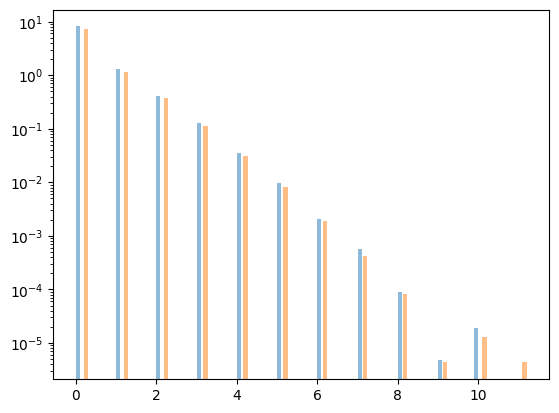

In [58]:
# model_Ntot
# base_dist_Ntot
# 203968/1817977 
cond_out = model.conv_layers(cond_tensor_jd[0])
cond_out = torch.cat((cond_out, cond_tensor_nsh_jd[0]), dim=1)
# if self.sep_Ntot_cond:
cond_out_Ntot = model.cond_Ntot_layer(cond_out)

Ntot_samp_tensor = model_Ntot.inverse(cond_out_Ntot)
Ntot_samp = np.maximum(np.round(Ntot_samp_tensor.cpu().detach().numpy()) - 1, 0).astype(int)
pl.figure()
_ = pl.hist(Ntot_samp, bins=100, density=True, alpha=0.5)
_ = pl.hist(0.2+Nhalos_truth_tensor_jd[0,...].cpu().detach().numpy(), bins=100, density=True, alpha=0.5)
pl.yscale('log')



In [8]:
# # for jf in range(7):
# #     save_bestfit_model_name = save_bestfit_model_dir + '/flow_' + str(jf)
# #     bestfit_model = (torch.load(save_bestfit_model_name))
# #     loss_min = bestfit_model['loss_min']
# #     print(loss_min)

# num_cond_Ntot = num_cond

# model_Ntot = SumGaussModel(
#     hidden_dim=hidden_dim_MAF,
#     num_cond=num_cond_Ntot,
#     ngauss=return_dict_train['ngauss_Nhalo'],
#     mu_all=return_dict_train['mu_all'],
#     sig_all=return_dict_train['sig_all'],
#     base_dist=base_dist_Ntot   
#     )

# num_cond_M1 = num_cond + 1
# # if conditioned on fastpm we will also give the fastpm fof M1 halos and its mask as conditional
# if cond_sim == 'fastpm':
#     num_cond_M1 += 2

# model_M1 = NSF_M1_CNNcond(
#     K=K_M1,
#     B=B_M1,
#     hidden_dim=hidden_dim_MAF,
#     num_cond=num_cond_M1,
#     nflows=nflows_M1_NSF,
#     base_dist=base_dist_M1,
#     ngauss=ngauss_M1,
#     lgM_rs_tointerp=lgM_rescaled,
#     hmf_pdf_tointerp=hmf_pdf,
#     hmf_cdf_tointerp=hmf_cdf    
#     )

# ndim_diff = return_dict_train['M_diff_halos_all_norm_masked'][0].shape[2]
# num_cond_Mdiff = num_cond + 2
# model_Mdiff = NSF_Mdiff_CNNcond(
#     dim=ndim_diff,
#     K=K_Mdiff,
#     B=B_Mdiff,
#     hidden_dim=hidden_dim_MAF,
#     num_cond=num_cond_Mdiff,
#     nflows=nflows_Mdiff_NSF,
#     base_dist=base_dist_Mdiff,
#     mu_pos=True
#     )

# ndim = ndim_diff + 1
# model = COMBINED_Model(
#     None,
#     model_Mdiff,
#     # None,
#     model_M1,
#     model_Ntot,
#     ndim,
#     ksize,
#     ns_d,
#     ns_h,
#     nb,
#     ninp,
#     nfeature_cnn,
#     nout_cnn,
#     layers_types=layers_types,
#     act='tanh',
#     padding='valid',
#     sep_Ntot_cond=True,
#     sep_M1_cond=True,
#     sep_Mdiff_cond=True,
#     num_cond_Ntot = num_cond_Ntot,
#     num_cond_M1 = num_cond_M1,
#     num_cond_Mdiff = num_cond_Mdiff
#     )

# model.to(dev)

# print()

# optimizer = optim.Adam(model.parameters(), lr=learning_rate)

# loss_all_it = []
# loss_min = 1e20
# epoch_tot_counter = 0
# scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min', factor=0.5, patience=200, verbose=True, cooldown=200, min_lr=1e-8)

# save_bestfit_model_name = save_bestfit_model_dir + '/flow_' + str(0)
# bestfit_model = (torch.load(save_bestfit_model_name))
# model.load_state_dict(bestfit_model['state_dict'])
# optimizer.load_state_dict(bestfit_model['optimizer'])
# scheduler.load_state_dict(bestfit_model['scheduler'])
# # loss_min = bestfit_model['loss_min']
# loss = bestfit_model['loss']


In [9]:
print(loss)


tensor([-1.2101], device='cuda:0', requires_grad=True)


In [10]:
# print('loading bestfit model')
# bestfit_model = (torch.load(save_bestfit_model_name))
# model.load_state_dict(bestfit_model['state_dict'])
# optimizer.load_state_dict(bestfit_model['optimizer'])
# scheduler.load_state_dict(bestfit_model['scheduler'])
# loss_min = bestfit_model['loss_min']
# loss = bestfit_model['loss']
# lr = bestfit_model['lr']
# epoch_tot_counter = bestfit_model['epoch_tot_counter']
# for g in optimizer.param_groups:
#     g['lr'] = lr

# print(loss_min, epoch_tot_counter, lr)




In [71]:
import readfof
import numpy as np
import pickle as pk 
# from nbodykit.lab import *
import h5py as h5
import numpy as np
import Pk_library as PKL
import MAS_library as MASL
import yaml

print(loss_min, epoch_tot_counter, stype)

train_Ntot, train_M1, train_Mdiff = 1, 0, 0
# train_Ntot, train_M1, train_Mdiff = 1, 1, 0
# train_Ntot, train_M1, train_Mdiff = 1, 0, 0
isim_start = 1
isim_end = 2
isim_all = np.arange(isim_start, isim_end).astype(int)
for ji in range(len(isim_all)):
    saved_all_jsim = {}
    # now we load the test data
    isim = isim_all[ji]
    print('DOING SIM NUMBER:' + str(isim))
    nstart = 0
    nsims_test = 512
    df_d_all_test, df_d_all_nsh_test, df_Mh_all_test, df_Nh_test, _ = load_density_halo_data_NGP(
        [isim], ns_d, nb, nf, nc, z_all, ns_h,sdir='/mnt/home/spandey/ceph/Quijote/data_NGP_self',
        stype=stype, mass_type=mass_type, lgMmincutstr = lgMmincutstr, is_HR=is_HR
        )

    if cond_sim == 'fastpm':
        df_d_all_test_FP, df_d_all_nsh_test_FP, df_Mh_all_test_FP, df_Nh_test_FP, _ = load_density_halo_data_NGP(
            [isim], ns_d, nb, nf, nc, z_all_FP, ns_h,sdir='/mnt/home/spandey/ceph/Quijote/data_NGP_self/fastpm',
            stype=stype
            )

    # things are too big to load all at once, so we load in batches
    nq = nb**3 // nsims_test
    save_subvol_Nhalo = np.zeros((nb**3, nax_h, nax_h, nax_h))
    save_subvol_Nhalo_truth = np.zeros((nb**3, nax_h, nax_h, nax_h))
    cond_z0_truth = np.zeros((nb**3, nax_h, nax_h, nax_h))
    save_subvol_M1 = np.zeros((nb**3, nax_h, nax_h, nax_h, 1))
    save_subvol_M1_truth = np.zeros((nb**3, nax_h, nax_h, nax_h, 1))
    save_subvol_Mdiff = np.zeros((nb**3, nax_h, nax_h, nax_h, ndim_diff))
    save_subvol_Mdiff_truth = np.zeros((nb**3, nax_h, nax_h, nax_h, ndim_diff))
    mask_subvol_Mtot = np.zeros((nb**3, nax_h, nax_h, nax_h, ndim_diff + 1))
    mask_subvol_Mtot_truth = np.zeros((nb**3, nax_h, nax_h, nax_h, ndim_diff + 1))

    # nfeatures_M1_tot = 20
    # cond_inp_M1_all = np.zeros((nb**3, nax_h, nax_h, nax_h, nfeatures_M1_tot))
    density_out_M1_loc_all_pad = np.zeros((nb**3, nax_h+6, nax_h+6, nax_h+6))
    density_out_M1_loc_all = np.zeros((nb**3, nax_h, nax_h, nax_h))

    nscount = 0
    for jq in range(nq):
        # Load the density data


        # Prepare the density and halo data
        return_dict_test = prep_density_halo_cats(
            df_d_all_test,
            df_d_all_nsh_test,
            df_Mh_all_test,
            df_Nh_test,
            nsims=nsims_test,
            nstart=nscount,
            Mmin=lgMmin, Mmax=lgMmax, rescaleM_sub=rescale_sub, Nmax=Nmax
            )
        
        if cond_sim == 'fastpm':
            return_dict_test_FP = prep_density_halo_cats(
                df_d_all_test_FP,
                df_d_all_nsh_test_FP,
                df_Mh_all_test_FP,
                df_Nh_test_FP,
                nsims=nsims_test,
                nstart=nscount,
                Mmin=lgMmin, Mmax=lgMmax, rescaleM_sub=rescale_sub
                )    

        if cond_sim == 'fastpm':
            cond_tensor_test = torch.Tensor(np.copy(np.array([return_dict_test_FP['df_d_all']]))).cuda(dev)
            cond_nsh_test = np.moveaxis(return_dict_test_FP['df_d_all_nsh'], 1, 4)
            cond_nsh_test = np.array([cond_nsh_test])
            cond_tensor_nsh_test = torch.Tensor(np.copy(cond_nsh_test.reshape(1,nsims_test * (nax_h ** 3), ninp))).cuda(dev)    
        else:
            cond_tensor_test = torch.Tensor(np.copy(np.array([return_dict_test['df_d_all']]))).cuda(dev)
            cond_nsh_test = np.moveaxis(return_dict_test['df_d_all_nsh'], 1, 4)
            cond_nsh_test = np.array([cond_nsh_test])
            cond_tensor_nsh_test = torch.Tensor(np.copy(cond_nsh_test.reshape(1,nsims_test * (nax_h ** 3), ninp))).cuda(dev)

        mask_tensor_M1_test = torch.Tensor(np.copy(return_dict_test['mask_M1'].reshape(1,nsims_test * (nax_h**3)))).cuda(dev)
        mask_tensor_Mdiff_test = torch.Tensor(
            (return_dict_test['mask_M_diff'].reshape(1,nsims_test * (nax_h**3), ndim_diff))
            ).cuda(dev)

        X_M1_test = torch.Tensor((return_dict_test['M1_halos_all_norm'].reshape(1,nsims_test * (nax_h**3), 1))).cuda(dev)
        X_Nhalo_test = torch.Tensor(return_dict_test['Nhalo_train_mg_arr'].reshape(1,nsims_test * (nax_h**3), 1)).cuda(dev)
        X_Mdiff_test = torch.Tensor(
            return_dict_test['M_diff_halos_all_norm_masked'].reshape(1,nsims_test * (nax_h**3), ndim_diff)
            ).cuda(dev)
        Nhalos_truth_tensor_test = torch.Tensor(((return_dict_test['N_halos_all'].reshape(1,nsims_test * (nax_h**3),
                                                                                        1)))).cuda(dev)
        
        if cond_sim == 'fastpm':
            mask_tensor_M1_test_FP = torch.Tensor(np.copy(return_dict_test_FP['mask_M1'].reshape(1,nsims_test * (nax_h**3)))).cuda(dev)
            # mask_tensor_Mdiff_test_FP = torch.Tensor(
            #     (return_dict_test_FP['mask_M_diff'].reshape(1,nsims_test * (nax_h**3), ndim_diff))
            #     ).cuda(dev)

            X_M1_test_FP = torch.Tensor((return_dict_test_FP['M1_halos_all_norm'].reshape(1,nsims_test * (nax_h**3), 1))).cuda(dev)
            X_Nhalo_test_FP = torch.Tensor(return_dict_test_FP['Nhalo_train_mg_arr'].reshape(1,nsims_test * (nax_h**3), 1)).cuda(dev)
            # X_Mdiff_test_FP = torch.Tensor(
            #     return_dict_test_FP['M_diff_halos_all_norm_masked'].reshape(1,nsims_test * (nax_h**3), ndim_diff)
            #     ).cuda(dev)
            Nhalos_truth_tensor_test_FP = torch.Tensor(((return_dict_test_FP['N_halos_all'].reshape(1,nsims_test * (nax_h**3),
                                                                                            1)))).cuda(dev)
        else:
            mask_tensor_M1_test_FP = None
            mask_tensor_Mdiff_test_FP = None
            X_M1_test_FP = None
            X_Nhalo_test_FP = None
            X_Mdiff_test_FP = None
            Nhalos_truth_tensor_test_FP = None

        Ntot_samp_test, M1_samp_test, M_diff_samp_test, mask_tensor_M1_samp_test, mask_tensor_Mdiff_samp_test, cond_inp_M1_test = model.inverse(
            cond_x=cond_tensor_test,
            cond_x_nsh=cond_tensor_nsh_test,
            use_truth_Nhalo=1-train_Ntot,
                use_truth_M1=1-train_M1,
                use_truth_Mdiff=1-train_Mdiff, 
            mask_Mdiff_truth=mask_tensor_Mdiff_test,
            mask_M1_truth=mask_tensor_M1_test,
            Nhalos_truth=X_Nhalo_test,
            M1_truth=X_M1_test,
            Mdiff_truth=X_Mdiff_test,
            train_Ntot=train_Ntot,
            train_M1=train_M1,
            train_Mdiff=train_Mdiff,
            x_M1_FP=X_M1_test_FP,   
            mask_M1_truth_all_FP=mask_tensor_M1_test_FP 
            )
        Ntot_samp_test = Ntot_samp_test[0][:,np.newaxis]
        # print(Ntot_samp_test.shape)
        save_subvol_Nhalo[nscount:nscount + nsims_test, ...] = Ntot_samp_test.reshape(nsims_test, nax_h, nax_h, nax_h)
        save_subvol_Nhalo_truth[nscount:nscount + nsims_test, ...] = Nhalos_truth_tensor_test.cpu().detach().numpy().reshape(nsims_test, nax_h, nax_h, nax_h)
        save_subvol_M1[nscount:nscount + nsims_test,
                    ...] = (M1_samp_test[0] * mask_tensor_M1_samp_test[0][:,0]
                            ).cpu().detach().numpy().reshape(nsims_test, nax_h, nax_h, nax_h, 1)
        save_subvol_M1_truth[nscount:nscount + nsims_test,
                    ...] = (X_M1_test[0][:,0] * mask_tensor_M1_test[0]
                            ).cpu().detach().numpy().reshape(nsims_test, nax_h, nax_h, nax_h, 1)    
        # cond_inp_M1_all[nscount:nscount + nsims_test,
        #                ...] = cond_inp_M1_test[0].cpu().detach().numpy().reshape(nsims_test, nax_h, nax_h, nax_h, nfeatures_M1_tot)
        # density_out_M1_loc_all_pad[nscount:nscount + nsims_test,...] = (cond_tensor_test[0,:,0,...].cpu().detach().numpy())
        # density_out_M1_loc_all[nscount:nscount + nsims_test,...] = (cond_nsh_test[0,...,0])

        save_subvol_Mdiff[nscount:nscount + nsims_test,
                        ...] = (M_diff_samp_test[0] * mask_tensor_Mdiff_samp_test[0]
                                ).cpu().detach().numpy().reshape(nsims_test, nax_h, nax_h, nax_h, ndim_diff)
        
        save_subvol_Mdiff_truth[nscount:nscount + nsims_test,
                        ...] = (X_Mdiff_test[0] * mask_tensor_Mdiff_test[0]
                                ).cpu().detach().numpy().reshape(nsims_test, nax_h, nax_h, nax_h, ndim_diff)
        
        mask_subvol_Mtot[nscount:nscount + nsims_test, ...,
                        0] = mask_tensor_M1_samp_test[0].cpu().detach().numpy().reshape(nsims_test, nax_h, nax_h, nax_h)
        mask_subvol_Mtot[
            nscount:nscount + nsims_test, ...,
            1:] = mask_tensor_Mdiff_samp_test[0].cpu().detach().numpy().reshape(nsims_test, nax_h, nax_h, nax_h, ndim_diff)

        mask_subvol_Mtot_truth[nscount:nscount + nsims_test, ...,
                        0] = mask_tensor_M1_test[0].cpu().detach().numpy().reshape(nsims_test, nax_h, nax_h, nax_h)
        mask_subvol_Mtot_truth[
            nscount:nscount + nsims_test, ...,
            1:] = mask_tensor_Mdiff_test[0].cpu().detach().numpy().reshape(nsims_test, nax_h, nax_h, nax_h, ndim_diff)
        
        
        cond_z0_truth[nscount:nscount + nsims_test, ...] = cond_tensor_nsh_test[0].cpu().detach().numpy().reshape(nsims_test, nax_h, nax_h, nax_h, ninp)[...,0]
        # print(nscount, nscount + nsims_test)

        nscount += nsims_test
        torch.cuda.empty_cache()


    save_subvol_Mtot = np.zeros((nb**3, nax_h, nax_h, nax_h, ndim_diff + 1))
    Mmin, Mmax = return_dict_test['Mmin'], return_dict_test['Mmax']
    for jd in range(ndim_diff + 1):
        if jd == 0:
            save_subvol_Mtot[..., jd] = (save_subvol_M1[..., 0] + 0.5) * (Mmax - Mmin) + Mmin
        else:
            save_subvol_Mtot[...,
                            jd] = (save_subvol_Mtot[..., jd - 1]) - (save_subvol_Mdiff[..., jd - 1]) * (Mmax - Mmin)


    save_subvol_Mtot *= mask_subvol_Mtot

    ind_less_Mmin = save_subvol_Mtot < Mmin
    ind_greater_Mmax = save_subvol_Mtot > Mmax
    save_subvol_Mtot[ind_less_Mmin] = 0.0
    save_subvol_Mtot[ind_greater_Mmax] = 0.0


    save_subvol_Mtot_truth = np.zeros((nb**3, nax_h, nax_h, nax_h, ndim_diff + 1))
    Mmin, Mmax = return_dict_test['Mmin'], return_dict_test['Mmax']
    for jd in range(ndim_diff + 1):
        if jd == 0:
            save_subvol_Mtot_truth[..., jd] = (save_subvol_M1_truth[..., 0] + 0.5) * (Mmax - Mmin) + Mmin
        else:
            save_subvol_Mtot_truth[...,
                            jd] = (save_subvol_Mtot_truth[..., jd - 1]) - (save_subvol_Mdiff_truth[..., jd - 1]) * (Mmax - Mmin)


    save_subvol_Mtot_truth *= mask_subvol_Mtot_truth
                

    sdir='/mnt/home/spandey/ceph/Quijote/data_NGP_self'
    # load the halo data
    if is_HR:
        fname = sdir + '/' + str(isim) + '/halos_HR_' + str(mass_type) + '_lgMmincut_' + lgMmincutstr + '_subvol_res_' + str(ns_h) + '_z=0.pk'
    else:
        fname = sdir + '/' + str(isim) + '/halos_' + str(mass_type) + '_lgMmincut_' + lgMmincutstr + '_subvol_res_' + str(ns_h) + '_z=0.pk'
    df_h_subvol = pk.load(open(fname, 'rb'))
    # This has information on the halo mass for all the halos in the voxel
    df_Mh_all_truth = df_h_subvol['M_halos']
    df_Mh_all_truth = np.flip(np.sort(df_Mh_all_truth, axis=-1), axis=-1)
    # This has information on the number of halos in the voxel
    df_Nh_truth = df_h_subvol['N_halos']

    if is_HR:
        fname = sdir + '/' + str(isim) + '/halos_HR_' + str(mass_type) + '_lgMmincut_' + lgMmincutstr + '_full_res_' + str(ns_h) + '_z=0.pk'
    else:
        fname = sdir + '/' + str(isim) + '/halos_' + str(mass_type) + '_lgMmincut_' + lgMmincutstr + '_full_res_' + str(ns_h) + '_z=0.pk'
    df_h_full = pk.load(open(fname, 'rb'))
    df_Mh_all_truth_comb, df_Nh_truth_comb = df_h_full['M_halos_combined'], df_h_full['N_halos_combined']

    delta_all_z0 = np.exp(df_d_all_nsh_test[:,0,...])-1

    bin_cents = np.array(np.arange(Nmax + 1))
    bin_edges = 0.5*(bin_cents[1:] + bin_cents[:-1])
    bin_edges = np.insert(bin_edges,0, -0.5)
    bin_edges = np.insert(bin_edges,len(bin_edges), bin_cents[-1] + 0.5)
    saved_all_jsim['Nhalo_bin_cents'] = bin_cents
    saved_all_jsim['Nhalo_bin_edges'] = bin_edges

    delta_min_p, delta_max_p= -1.0, 500
    indsel_dp = np.where((delta_all_z0 > delta_min_p) & (delta_all_z0 < delta_max_p))    
    hist_truth_all, _ = np.histogram(df_Nh_truth[indsel_dp], bins=bin_edges)
    hist_samp_all, _ = np.histogram(save_subvol_Nhalo[indsel_dp].flatten(), bins=bin_edges)
    saved_all_jsim['hist_truth_all_Nhalo'] = hist_truth_all
    saved_all_jsim['hist_samp_all_Nhalo'] = hist_samp_all
    print(hist_samp_all)
    print(hist_truth_all)

    delta_min_p, delta_max_p= -1.0, 0
    indsel_dp = np.where((delta_all_z0 > delta_min_p) & (delta_all_z0 < delta_max_p))    
    hist_truth_low, _ = np.histogram(df_Nh_truth[indsel_dp], bins=bin_edges)
    hist_samp_low, _ = np.histogram(save_subvol_Nhalo[indsel_dp].flatten(), bins=bin_edges)
    saved_all_jsim['hist_truth_low_Nhalo'] = hist_truth_low
    saved_all_jsim['hist_samp_low_Nhalo'] = hist_samp_low

    delta_min_p, delta_max_p= 0.0, 2.0
    indsel_dp = np.where((delta_all_z0 > delta_min_p) & (delta_all_z0 < delta_max_p))    
    hist_truth_mid, _ = np.histogram(df_Nh_truth[indsel_dp], bins=bin_edges)
    hist_samp_mid, _ = np.histogram(save_subvol_Nhalo[indsel_dp].flatten(), bins=bin_edges)
    saved_all_jsim['hist_truth_mid_Nhalo'] = hist_truth_mid
    saved_all_jsim['hist_samp_mid_Nhalo'] = hist_samp_mid

    delta_min_p, delta_max_p= 2.0, 500
    indsel_dp = np.where((delta_all_z0 > delta_min_p) & (delta_all_z0 < delta_max_p))    
    hist_truth_high, _ = np.histogram(df_Nh_truth[indsel_dp], bins=bin_edges)
    hist_samp_high, _ = np.histogram(save_subvol_Nhalo[indsel_dp].flatten(), bins=bin_edges)
    saved_all_jsim['hist_truth_high_Nhalo'] = hist_truth_high
    saved_all_jsim['hist_samp_high_Nhalo'] = hist_samp_high


    delta_all_z0 = np.exp(df_d_all_nsh_test[:,0,...])-1
    bin_cents_M = np.linspace(lgMmin, lgMmax, 20)[1:-1]
    bin_edges_M = 0.5*(bin_cents_M[1:] + bin_cents_M[:-1])
    delta_b = 0.5*(bin_cents_M[1] - bin_cents_M[0])
    bin_edges_M = np.insert(bin_edges_M,0, bin_cents_M[0] - delta_b)
    bin_edges_M = np.insert(bin_edges_M,len(bin_edges_M), bin_cents_M[-1] - delta_b)
    saved_all_jsim['Mhalo_bin_cents'] = bin_cents_M
    saved_all_jsim['Mhalo_bin_edges'] = bin_edges_M


    delta_min_p, delta_max_p = -1.0, 500.0
    indsel_dp = np.where((delta_all_z0 > delta_min_p) & (delta_all_z0 < delta_max_p))
    hist_M_truth_all = np.zeros((4, len(bin_cents_M)))
    hist_M_samp_all = np.zeros((4, len(bin_cents_M)))    
    for idim in range(4):
        M_idim_truth = df_Mh_all_truth[..., idim]
        hist_truth, _ = np.histogram(M_idim_truth[indsel_dp].flatten(), bins=bin_edges_M)
        hist_M_truth_all[idim, :] = hist_truth
        
        M_idim_samp = save_subvol_Mtot[..., idim]
        hist_sampled, _ = np.histogram(M_idim_samp[indsel_dp].flatten(), bins=bin_edges_M)
        hist_M_samp_all[idim, :] = hist_sampled
    saved_all_jsim['hist_truth_all_Mhalo'] = hist_M_truth_all
    saved_all_jsim['hist_samp_all_Mhalo'] = hist_M_samp_all

    delta_min_p, delta_max_p = -1.0, 0.0
    indsel_dp = np.where((delta_all_z0 > delta_min_p) & (delta_all_z0 < delta_max_p))
    hist_M_truth_low = np.zeros((4, len(bin_cents_M)))
    hist_M_samp_low = np.zeros((4, len(bin_cents_M)))
    for idim in range(4):
        M_idim_truth = df_Mh_all_truth[..., idim]
        hist_truth, _ = np.histogram(M_idim_truth[indsel_dp].flatten(), bins=bin_edges_M)
        hist_M_truth_low[idim, :] = hist_truth
        
        M_idim_samp = save_subvol_Mtot[..., idim]
        hist_sampled, _ = np.histogram(M_idim_samp[indsel_dp].flatten(), bins=bin_edges_M)
        hist_M_samp_low[idim, :] = hist_sampled
    saved_all_jsim['hist_truth_low_Mhalo'] = hist_M_truth_low
    saved_all_jsim['hist_samp_low_Mhalo'] = hist_M_samp_low

    delta_min_p, delta_max_p = 0.0, 2.0
    indsel_dp = np.where((delta_all_z0 > delta_min_p) & (delta_all_z0 < delta_max_p))
    hist_M_truth_mid = np.zeros((4, len(bin_cents_M)))
    hist_M_samp_mid = np.zeros((4, len(bin_cents_M)))
    for idim in range(4):
        M_idim_truth = df_Mh_all_truth[..., idim]
        hist_truth, _ = np.histogram(M_idim_truth[indsel_dp].flatten(), bins=bin_edges_M)
        hist_M_truth_mid[idim, :] = hist_truth
        
        M_idim_samp = save_subvol_Mtot[..., idim]
        hist_sampled, _ = np.histogram(M_idim_samp[indsel_dp].flatten(), bins=bin_edges_M)
        hist_M_samp_mid[idim, :] = hist_sampled
    saved_all_jsim['hist_truth_mid_Mhalo'] = hist_M_truth_mid
    saved_all_jsim['hist_samp_mid_Mhalo'] = hist_M_samp_mid

    delta_min_p, delta_max_p = 2.0, 500.0
    indsel_dp = np.where((delta_all_z0 > delta_min_p) & (delta_all_z0 < delta_max_p))
    hist_M_truth_high = np.zeros((4, len(bin_cents_M)))
    hist_M_samp_high = np.zeros((4, len(bin_cents_M)))
    for idim in range(4):
        M_idim_truth = df_Mh_all_truth[..., idim]
        hist_truth, _ = np.histogram(M_idim_truth[indsel_dp].flatten(), bins=bin_edges_M)
        hist_M_truth_high[idim, :] = hist_truth
        
        M_idim_samp = save_subvol_Mtot[..., idim]
        hist_sampled, _ = np.histogram(M_idim_samp[indsel_dp].flatten(), bins=bin_edges_M)
        hist_M_samp_high[idim, :] = hist_sampled
    saved_all_jsim['hist_truth_high_Mhalo'] = hist_M_truth_high
    saved_all_jsim['hist_samp_high_Mhalo'] = hist_M_samp_high

    # # import pdb; pdb.set_trace()

    # create empty arrays for Nhalos and M_halos
    Nhalos = np.zeros((ns_h, ns_h, ns_h))
    M_halos = np.zeros((ns_h, ns_h, ns_h, ndim_diff + 1))
    M_halos_truth = np.zeros((ns_h, ns_h, ns_h, ndim_diff + 1))

    subvol_size = ns_h // nb

    ind_cart_lin = {}
    ind_lin_cart = {}
    jc = 0
    from tqdm import tqdm
    for jx in tqdm(range(nb)):
        for jy in range(nb):
            for jz in range(nb):
                # get the sub-cube
                ind_lin_cart[(jx, jy, jz)] = jc
                ind_cart_lin[jc] = [jx, jy, jz]
                jc += 1
                

    # iterate over subvolumes
    jc = 0
    for jx in range(nb):
        for jy in range(nb):
            for jz in range(nb):
                Nhalos[jx * subvol_size:(jx + 1) * subvol_size, jy * subvol_size:(jy + 1) * subvol_size,
                    jz * subvol_size:(jz + 1) * subvol_size] = save_subvol_Nhalo[ind_lin_cart[(jx, jy, jz)]]

                M_halos[jx * subvol_size:(jx + 1) * subvol_size, jy * subvol_size:(jy + 1) * subvol_size,
                        jz * subvol_size:(jz + 1) * subvol_size, :] = save_subvol_Mtot[ind_lin_cart[(jx, jy, jz)]]
                
                
                jc += 1
                
                
    
    # create empty arrays for Nhalos and M_halos
    Nhalos_truth_recomb = np.zeros((ns_h, ns_h, ns_h))
    M_halos_truth_recomb = np.zeros((ns_h, ns_h, ns_h, ndim_diff + 1))

    subvol_size = ns_h // nb

    ind_cart_lin = {}
    ind_lin_cart = {}
    jc = 0
    from tqdm import tqdm
    for jx in tqdm(range(nb)):
        for jy in range(nb):
            for jz in range(nb):
                # get the sub-cube
                ind_lin_cart[(jx, jy, jz)] = jc
                ind_cart_lin[jc] = [jx, jy, jz]
                jc += 1
                

    # iterate over subvolumes
    jc = 0
    for jx in range(nb):
        for jy in range(nb):
            for jz in range(nb):
                Nhalos_truth_recomb[jx * subvol_size:(jx + 1) * subvol_size, jy * subvol_size:(jy + 1) * subvol_size,
                    jz * subvol_size:(jz + 1) * subvol_size] = df_Nh_truth[ind_lin_cart[(jx, jy, jz)]]

                M_halos_truth_recomb[jx * subvol_size:(jx + 1) * subvol_size, jy * subvol_size:(jy + 1) * subvol_size,
                        jz * subvol_size:(jz + 1) * subvol_size, :] = df_Mh_all_truth[ind_lin_cart[(jx, jy, jz)]]
                
                
                jc += 1
                

    # create the meshgrid
    zv = 0.0
    av = 1. / (1 + zv)
    xall = (np.linspace(0, 1000, ns_h + 1))
    xarray = av * 0.5 * (xall[1:] + xall[:-1])
    yarray = np.copy(xarray)
    zarray = np.copy(xarray)
    x_cy, y_cy, z_cy = np.meshgrid(xarray, yarray, zarray, indexing='ij')


    # create the meshgrid
    zv = 0.0
    av = 1. / (1 + zv)
    xall = (np.linspace(0, 1000, ns_h + 1))
    xarray = av * 0.5 * (xall[1:] + xall[:-1])
    dx = (xall[1] - xall[0])
    yarray = np.copy(xarray)
    zarray = np.copy(xarray)
    x_cy, y_cy, z_cy = np.meshgrid(xarray, yarray, zarray, indexing='ij')

    x_h_mock, y_h_mock, z_h_mock, lgM_mock = [], [], [], []
    k = 0
    for jx in range(ns_h):
        for jy in range(ns_h):
            for jz in range(ns_h):
                    Nh_vox = int(Nhalos[jx, jy, jz])
                    if Nh_vox > 0:
                        x_h_mock.append(x_cy[jx, jy, jz]*np.ones(Nh_vox))
                        y_h_mock.append(y_cy[jx, jy, jz]*np.ones(Nh_vox))
                        z_h_mock.append(z_cy[jx, jy, jz]*np.ones(Nh_vox))
                        
                        lgM_mock.append((M_halos[jx, jy, jz, :Nh_vox]))
                        k += Nh_vox

    # convert to numpy arrays
    x_h_mock = np.concatenate(x_h_mock)
    y_h_mock = np.concatenate(y_h_mock)
    z_h_mock = np.concatenate(z_h_mock)
    pos_h_mock = np.vstack((x_h_mock, y_h_mock, z_h_mock)).T
    lgMass_mock = np.concatenate(lgM_mock)
    # convert to float data type
    pos_h_mock = pos_h_mock.astype('float32')
    lgMass_mock = lgMass_mock.astype('float32')


    # sdir='/mnt/home/spandey/ceph/Quijote/data_NGP_self'
    # # load the halo data
    # fname = sdir + '/' + str(isim) + '/halos_' + str(mass_type) + '_subvol_res_' + str(ns_h) + '_z=0.pk'
    # df_h = pk.load(open(fname, 'rb'))
    # # This has information on the halo mass for all the halos in the voxel
    # df_Mh_all_truth = df_h['M_halos']
    # df_Mh_all_truth = np.flip(np.sort(df_Mh_all_truth, axis=-1), axis=-1)
    # # This has information on the number of halos in the voxel
    # df_Nh_truth = df_h['N_halos']

    # fname = sdir + '/' + str(isim) + '/halos_' + str(mass_type) + '_full_res_' + str(ns_h) + '_z=0.pk'
    # df_h = pk.load(open(fname, 'rb'))
    # df_Mh_all_truth_comb, df_Nh_truth_comb = df_h['M_halos_combined'], df_h['N_halos_combined']

    # create the meshgrid
    zv = 0.0
    av = 1. / (1 + zv)
    xall = (np.linspace(0, 1000, ns_h + 1))
    xarray = av * 0.5 * (xall[1:] + xall[:-1])
    dx = (xall[1] - xall[0])
    yarray = np.copy(xarray)
    zarray = np.copy(xarray)
    x_cy, y_cy, z_cy = np.meshgrid(xarray, yarray, zarray, indexing='ij')

    x_h_truth, y_h_truth, z_h_truth, lgM_truth = [], [], [], []
    for jx in range(ns_h):
        for jy in range(ns_h):
            for jz in range(ns_h):
                    Nh_vox = int(df_Nh_truth_comb[jx, jy, jz])
                    if Nh_vox > 0:
                        x_h_truth.append(x_cy[jx, jy, jz]*np.ones(Nh_vox))
                        y_h_truth.append(y_cy[jx, jy, jz]*np.ones(Nh_vox))
                        z_h_truth.append(z_cy[jx, jy, jz]*np.ones(Nh_vox))
                        
                        lgM_truth.append((df_Mh_all_truth_comb[jx, jy, jz, :Nh_vox]))

    # convert to numpy arrays
    x_h_truth = np.concatenate(x_h_truth)
    y_h_truth = np.concatenate(y_h_truth)
    z_h_truth = np.concatenate(z_h_truth)
    pos_h_truth = np.vstack((x_h_truth, y_h_truth, z_h_truth)).T
    lgMass_truth = np.concatenate(lgM_truth)
    # convert to float data type
    pos_h_truth = pos_h_truth.astype('float32')
    lgMass_truth = lgMass_truth.astype('float32')

    grid    = ns_h    #the 3D field will have grid x grid x grid voxels
    BoxSize = 1000.0 #Mpc/h ; size of box
    MAS     = 'NGP'  #mass-assigment scheme
    verbose = False   #print information on progress

    # Mmin_Pk_all = np.array([13.0, 13.0, 13.5, 14.0, 14.5])
    # Mmax_Pk_all = np.array([16.0, 13.5, 14.0, 14.5, 15.0])
    Mmin_Pk_all = np.log10(np.array([1e13, 5e13, 7e13, 1e14, 5e14]))
    Mmax_Pk_all = np.log10(np.array([1e16, 7e13, 1e14, 5e14, 1e15]))  
    Mmin_Pk_all[0] = -1.0

    saved_Pk_Bk = {}

    for j in range(len(Mmin_Pk_all)):
        saved_j = {}
        Mmin_Pk, Mmax_Pk = Mmin_Pk_all[j], Mmax_Pk_all[j]
        indsel_Pk_truth = np.where((lgMass_truth > Mmin_Pk) & (lgMass_truth < Mmax_Pk))[0]
        mesh_truth2 = np.zeros((grid, grid, grid), dtype=np.float32)
        pos_truth2 = (pos_h_truth[indsel_Pk_truth,...]).astype(np.float32)
        MASL.MA(pos_truth2, mesh_truth2, BoxSize, MAS)
        mesh_truth2 /= np.mean(mesh_truth2, dtype=np.float64);  mesh_truth2 -= 1.0
        Pk_truth2 = PKL.Pk(mesh_truth2, BoxSize, axis=0, MAS=None, threads=1)

        indsel_Pk_mock = np.where((lgMass_mock > Mmin_Pk) & (lgMass_mock < Mmax_Pk))[0]
        mesh_mock = np.zeros((grid, grid, grid), dtype=np.float32)
        pos_mock = (pos_h_mock[indsel_Pk_mock,...]).astype(np.float32)
        MASL.MA(pos_mock, mesh_mock, BoxSize, MAS)
        mesh_mock /= np.mean(mesh_mock, dtype=np.float64);  mesh_mock -= 1.0
        Pk_mock = PKL.Pk(mesh_mock, BoxSize, axis=0, MAS=None, threads=1)    

        Pk_mockxtruth2 = PKL.XPk([mesh_truth2,mesh_mock], BoxSize, axis=0, MAS=[None, None], threads=1)

        saved_j['Pk_truth'] = Pk_truth2.Pk[:,0]
        saved_j['Pk_mock'] = Pk_mock.Pk[:,0]
        saved_j['Pk_mockxtruth'] = Pk_mockxtruth2.XPk[:,0,0]
        saved_j['k_Pk'] = Pk_mockxtruth2.k3D
        

    #     BoxSize = 1000.0 #Size of the density field in Mpc/h
    #     threads = 1
    #     theta   = np.linspace(0, np.pi, 16) #array with the angles between k1 and k2
    #     saved_j['theta'] = theta

    #     k1 = 0.03
    #     k2 = 0.03
    #     BBk = PKL.Bk(mesh_truth2, BoxSize, k1, k2, theta, None, threads)
    #     Bk_truth_k0p03  = BBk.B     #bispectrum
    #     Qk_truth_k0p03  = BBk.Q     #reduced bispectrum
    #     BBk = PKL.Bk(mesh_mock, BoxSize, k1, k2, theta, None, threads)
    #     Bk_mock_k0p03  = BBk.B     #bispectrum
    #     Qk_mock_k0p03  = BBk.Q     #reduced bispectrum

    #     saved_j['Bk_truth_k0p03'] = Bk_truth_k0p03
    #     saved_j['Qk_truth_k0p03'] = Qk_truth_k0p03
    #     saved_j['Bk_mock_k0p03'] = Bk_mock_k0p03
    #     saved_j['Qk_mock_k0p03'] = Qk_mock_k0p03


    #     k1 = 0.06
    #     k2 = 0.06
    #     BBk = PKL.Bk(mesh_truth2, BoxSize, k1, k2, theta, None, threads)
    #     Bk_truth_k0p06  = BBk.B     #bispectrum
    #     Qk_truth_k0p06  = BBk.Q     #reduced bispectrum
    #     BBk = PKL.Bk(mesh_mock, BoxSize, k1, k2, theta, None, threads)
    #     Bk_mock_k0p06  = BBk.B     #bispectrum
    #     Qk_mock_k0p06  = BBk.Q     #reduced bispectrum

    #     saved_j['Bk_truth_k0p06'] = Bk_truth_k0p06
    #     saved_j['Qk_truth_k0p06'] = Qk_truth_k0p06
    #     saved_j['Bk_mock_k0p06'] = Bk_mock_k0p06
    #     saved_j['Qk_mock_k0p06'] = Qk_mock_k0p06

    #     k1 = 0.1
    #     k2 = 0.1
    #     BBk = PKL.Bk(mesh_truth2, BoxSize, k1, k2, theta, None, threads)
    #     Bk_truth_k0p1  = BBk.B     #bispectrum
    #     Qk_truth_k0p1  = BBk.Q     #reduced bispectrum
    #     BBk = PKL.Bk(mesh_mock, BoxSize, k1, k2, theta, None, threads)
    #     Bk_mock_k0p1  = BBk.B     #bispectrum
    #     Qk_mock_k0p1  = BBk.Q     #reduced bispectrum

    #     saved_j['Bk_truth_k0p1'] = Bk_truth_k0p1
    #     saved_j['Qk_truth_k0p1'] = Qk_truth_k0p1
    #     saved_j['Bk_mock_k0p1'] = Bk_mock_k0p1
    #     saved_j['Qk_mock_k0p1'] = Qk_mock_k0p1


    #     k1 = 0.2
    #     k2 = 0.2
    #     BBk = PKL.Bk(mesh_truth2, BoxSize, k1, k2, theta, None, threads)
    #     Bk_truth_k0p2  = BBk.B     #bispectrum
    #     Qk_truth_k0p2  = BBk.Q     #reduced bispectrum
    #     BBk = PKL.Bk(mesh_mock, BoxSize, k1, k2, theta, None, threads)
    #     Bk_mock_k0p2  = BBk.B     #bispectrum
    #     Qk_mock_k0p2  = BBk.Q     #reduced bispectrum

    #     saved_j['Bk_truth_k0p2'] = Bk_truth_k0p2
    #     saved_j['Qk_truth_k0p2'] = Qk_truth_k0p2
    #     saved_j['Bk_mock_k0p2'] = Bk_mock_k0p2
    #     saved_j['Qk_mock_k0p2'] = Qk_mock_k0p2


    #     k1 = 0.3
    #     k2 = 0.3
    #     BBk = PKL.Bk(mesh_truth2, BoxSize, k1, k2, theta, None, threads)
    #     Bk_truth_k0p3  = BBk.B     #bispectrum
    #     Qk_truth_k0p3  = BBk.Q     #reduced bispectrum
    #     BBk = PKL.Bk(mesh_mock, BoxSize, k1, k2, theta, None, threads)
    #     Bk_mock_k0p3  = BBk.B     #bispectrum
    #     Qk_mock_k0p3  = BBk.Q     #reduced bispectrum

    #     saved_j['Bk_truth_k0p3'] = Bk_truth_k0p3
    #     saved_j['Qk_truth_k0p3'] = Qk_truth_k0p3
    #     saved_j['Bk_mock_k0p3'] = Bk_mock_k0p3
    #     saved_j['Qk_mock_k0p3'] = Qk_mock_k0p3

    #     # k1 = 0.4
    #     # k2 = 0.4
    #     # BBk = PKL.Bk(mesh_truth2, BoxSize, k1, k2, theta, None, threads)
    #     # Bk_truth_k0p4  = BBk.B     #bispectrum
    #     # Qk_truth_k0p4  = BBk.Q     #reduced bispectrum
    #     # BBk = PKL.Bk(mesh_mock, BoxSize, k1, k2, theta, None, threads)
    #     # Bk_mock_k0p4  = BBk.B     #bispectrum
    #     # Qk_mock_k0p4  = BBk.Q     #reduced bispectrum

    #     # saved_j['Bk_truth_k0p4'] = Bk_truth_k0p4
    #     # saved_j['Qk_truth_k0p4'] = Qk_truth_k0p4
    #     # saved_j['Bk_mock_k0p4'] = Bk_mock_k0p4
    #     # saved_j['Qk_mock_k0p4'] = Qk_mock_k0p4
    
        saved_Pk_Bk[j] = saved_j

    saved_all_jsim['Pk_Bk'] = saved_Pk_Bk

    # # # sdir = '/mnt/home/spandey/ceph/AR_NPE/notebooks/SUMMARY_STATS_FIDSIMS_TEST_stype_' + str(stype) + '_mtype_' + str(mass_type) + '_condsim_' + str(cond_sim) + '/'
    # # # sdir = '/mnt/home/spandey/ceph/AR_NPE/notebooks/SUMMARY_STATS_FIDSIMS_TEST_stype_' + str(stype) + '_mtype_' + str(mass_type) + '_condsim_' + str(cond_sim) + '_nc_' + str(nc) + '/'    
    # # sdir = '/mnt/home/spandey/ceph/AR_NPE/notebooks/SUMMARY_STATS_FIDSIMS_TEST_stype_' + str(stype) + '_mtype_' + str(mass_type) + '_condsim_' + str(cond_sim) + '_nc_' + str(nc) + '_wL2norm_highknots' + '/'    
    # # print(sdir)
    # # # make directory if doesn't exist:
    # # if not os.path.exists(sdir):
    # #     os.makedirs(sdir)
    # # import pickle as pk
    # # fname = sdir + '/summary_stats_jsim_' + str(isim) + '.pk'
    # # pk.dump(saved_all_jsim, open(fname, 'wb'))

                    








0.20969092845916748 5000 cic
DOING SIM NUMBER:1
[1730121  256321   78812   23499    6360    1616     338      75      10
       0       0       0]
[1727358  258423   79364   23661    6363    1535     355      79      10
       2       2       0]


100%|██████████| 8/8 [00:00<00:00, 34556.57it/s]



Computing power spectrum of the field...
Time to complete loop = 0.06
Time taken = 0.08 seconds

Computing power spectrum of the field...
Time to complete loop = 0.06
Time taken = 0.09 seconds

Computing power spectra of the fields...
Time FFTS = 0.03
Time loop = 0.04
Time taken = 0.08 seconds

Computing power spectrum of the field...
Time to complete loop = 0.06
Time taken = 0.07 seconds

Computing power spectrum of the field...
Time to complete loop = 0.06
Time taken = 0.07 seconds

Computing power spectra of the fields...
Time FFTS = 0.02
Time loop = 0.04
Time taken = 0.06 seconds

Computing power spectrum of the field...
Time to complete loop = 0.06
Time taken = 0.07 seconds

Computing power spectrum of the field...
Time to complete loop = 0.06
Time taken = 0.07 seconds

Computing power spectra of the fields...
Time FFTS = 0.02
Time loop = 0.04
Time taken = 0.07 seconds

Computing power spectrum of the field...
Time to complete loop = 0.06
Time taken = 0.07 seconds

Computing powe

In [51]:
# # model_Ntot
# # base_dist_Ntot
# # 203968/1817977 
# cond_out = model.conv_layers(cond_tensor_jd[0])
# cond_out = torch.cat((cond_out, cond_tensor_nsh_jd[0]), dim=1)
# # if self.sep_Ntot_cond:
# cond_out_Ntot = model.cond_Ntot_layer(cond_out)

# Ntot_samp_tensor = model_Ntot.inverse(cond_out_Ntot)
# pl.figure()
# _ = pl.hist(Ntot_samp_tensor.cpu().detach().numpy(), bins=100, density=True, alpha=0.5)
# _ = pl.hist(Nhalos_truth_tensor_jd[0,...].cpu().detach().numpy(), bins=100, density=True, alpha=0.5)
# pl.yscale('log')


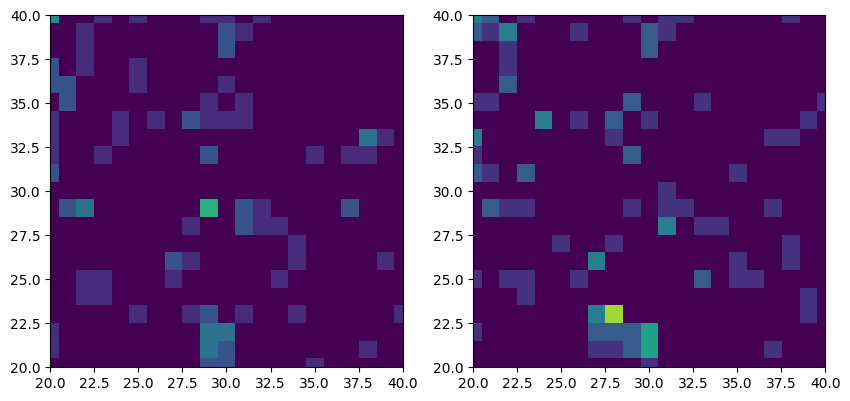

In [48]:
# pl.figure()
# pl.imshow(Nhalos[64,...])
# make it a two panel figure:
pl.figure(figsize=(10, 5))
pl.subplot(121)
pl.imshow(Nhalos[64,...])
pl.xlim(20,40)
pl.ylim(20,40)

pl.subplot(122)
pl.imshow(Nhalos_truth_recomb[64,...])
pl.xlim(20,40)
pl.ylim(20,40)
pl.show()




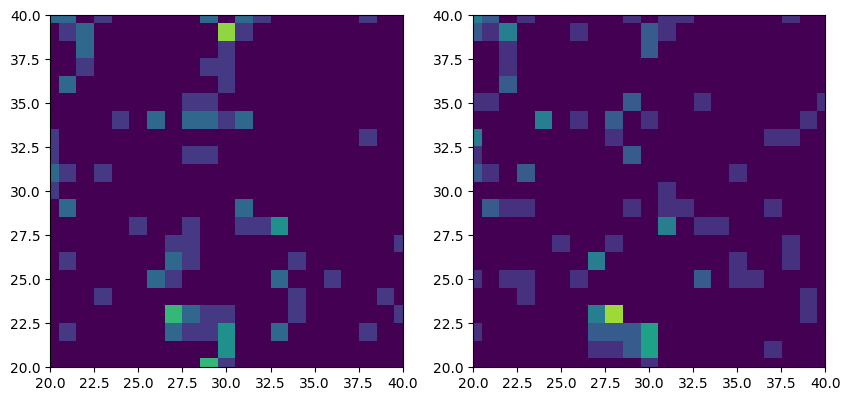

In [60]:
# pl.figure()
# pl.imshow(Nhalos[64,...])
# make it a two panel figure:
pl.figure(figsize=(10, 5))
pl.subplot(121)
pl.imshow(Nhalos[64,...])
pl.xlim(20,40)
pl.ylim(20,40)

pl.subplot(122)
pl.imshow(Nhalos_truth_recomb[64,...])
pl.xlim(20,40)
pl.ylim(20,40)
pl.show()




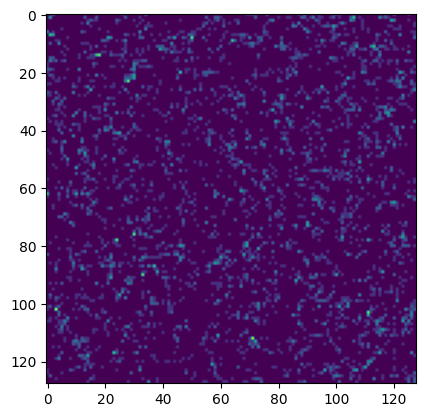

In [42]:
pl.figure()
pl.imshow(df_Nh_truth_comb[64,...])
# Nhalos.shape

In [64]:
# # Nhalos_truth_tensor_jd.shape
# if is_HR:
#     fname = sdir + '/' + str(isim) + '/halos_HR_' + str(mass_type) + '_lgMmincut_' + lgMmincutstr + '_full_res_' + str(ns_h) + '_z=0.pk'
# else:
#     fname = sdir + '/' + str(isim) + '/halos_' + str(mass_type) + '_lgMmincut_' + lgMmincutstr + '_full_res_' + str(ns_h) + '_z=0.pk'
# np.sum(df_Nh_truth_comb), np.sum(Nhalos)
# np.amin(lgMass_truth[lgMass_truth > 0]), np.amin(lgMass_mock[lgMass_mock > 0])
# np.amax(lgMass_truth[lgMass_truth > 0]), np.amax(lgMass_mock[lgMass_mock > 0])

len(pos_h_mock), len(pos_h_truth)



(530036, 524062)

In [65]:
# fname
len(pos_h_truth)/len(pos_h_mock)


0.9887290674595688

In [21]:
import matplotlib.pyplot as pl
import matplotlib
%matplotlib inline




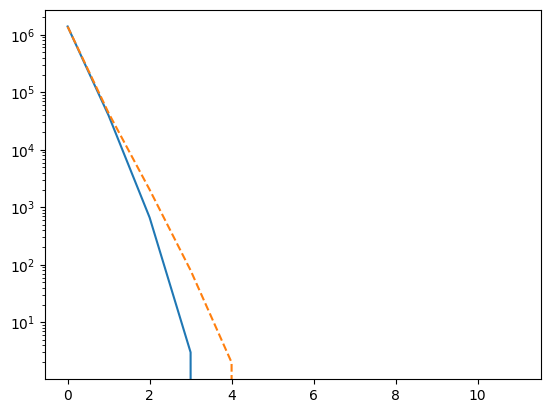

In [62]:
pl.figure()
pl.plot(saved_all_jsim['Nhalo_bin_cents'], saved_all_jsim['hist_truth_low_Nhalo'])
pl.plot(saved_all_jsim['Nhalo_bin_cents'], saved_all_jsim['hist_samp_low_Nhalo'], ls='--')
pl.yscale('log')




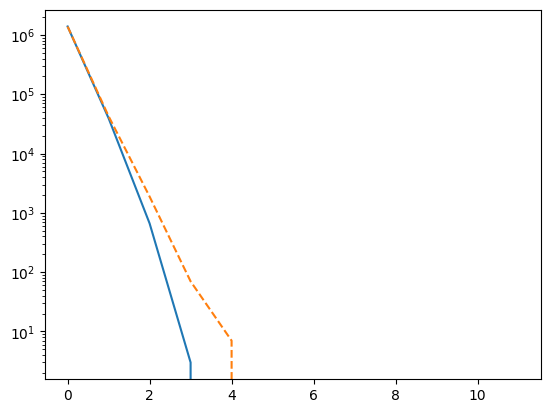

In [72]:
pl.figure()
pl.plot(saved_all_jsim['Nhalo_bin_cents'], saved_all_jsim['hist_truth_low_Nhalo'])
pl.plot(saved_all_jsim['Nhalo_bin_cents'], saved_all_jsim['hist_samp_low_Nhalo'], ls='--')
pl.yscale('log')




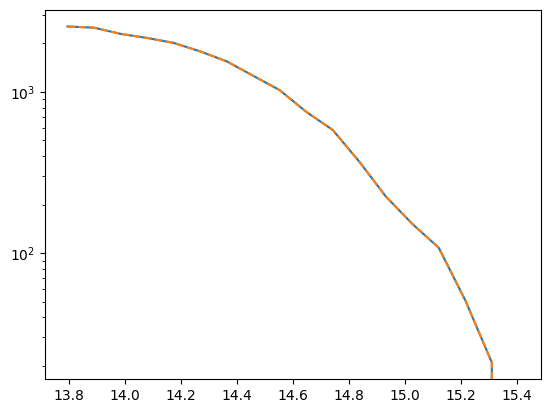

In [22]:
pl.figure()
pl.plot(saved_all_jsim['Mhalo_bin_cents'], saved_all_jsim['hist_truth_high_Mhalo'][0,:])
pl.plot(saved_all_jsim['Mhalo_bin_cents'], saved_all_jsim['hist_samp_high_Mhalo'][0,:], ls='--')
pl.yscale('log')




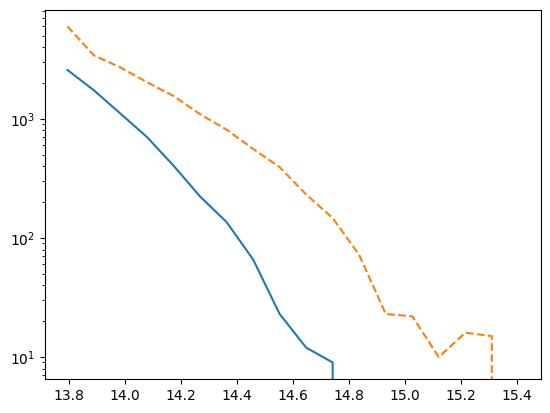

In [27]:
pl.figure()
pl.plot(saved_all_jsim['Mhalo_bin_cents'], saved_all_jsim['hist_truth_all_Mhalo'][1,:])
pl.plot(saved_all_jsim['Mhalo_bin_cents'], saved_all_jsim['hist_samp_all_Mhalo'][1,:], ls='--')
pl.yscale('log')




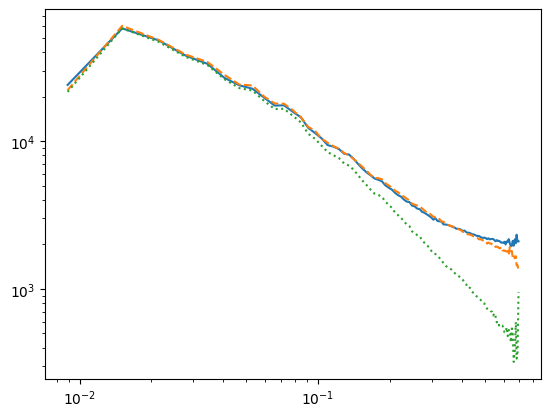

In [67]:
pl.figure()
pl.plot(saved_all_jsim['Pk_Bk'][0]['k_Pk'], saved_all_jsim['Pk_Bk'][0]['Pk_truth'])
pl.plot(saved_all_jsim['Pk_Bk'][0]['k_Pk'], saved_all_jsim['Pk_Bk'][0]['Pk_mock'], ls='--')
pl.plot(saved_all_jsim['Pk_Bk'][0]['k_Pk'], saved_all_jsim['Pk_Bk'][0]['Pk_mockxtruth'], ls=':')
pl.yscale('log')
pl.xscale('log')




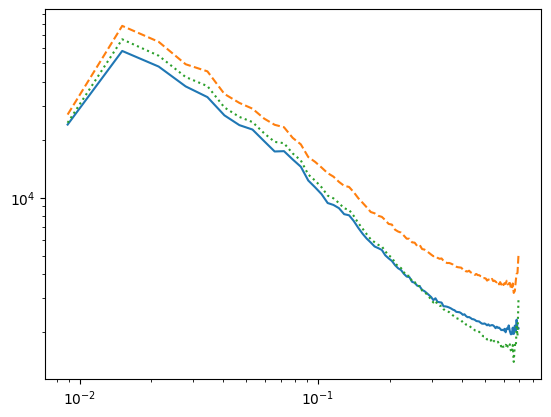

In [63]:
pl.figure()
pl.plot(saved_all_jsim['Pk_Bk'][0]['k_Pk'], saved_all_jsim['Pk_Bk'][0]['Pk_truth'])
pl.plot(saved_all_jsim['Pk_Bk'][0]['k_Pk'], saved_all_jsim['Pk_Bk'][0]['Pk_mock'], ls='--')
pl.plot(saved_all_jsim['Pk_Bk'][0]['k_Pk'], saved_all_jsim['Pk_Bk'][0]['Pk_mockxtruth'], ls=':')
pl.yscale('log')
pl.xscale('log')



In [15]:
sdir='/mnt/home/spandey/ceph/Quijote/data_NGP_self'
# load the halo data
fname = sdir + '/' + str(isim) + '/halos_' + str(mass_type) + '_lgMmincut_' + lgMmincutstr + '_subvol_res_' + str(ns_h) + '_z=0.pk'
df_h_subvol = pk.load(open(fname, 'rb'))
# This has information on the halo mass for all the halos in the voxel
df_Mh_all_truth = df_h_subvol['M_halos']
df_Mh_all_truth = np.flip(np.sort(df_Mh_all_truth, axis=-1), axis=-1)
# This has information on the number of halos in the voxel
df_Nh_truth = df_h_subvol['N_halos']

fname = sdir + '/' + str(isim) + '/halos_' + str(mass_type) + '_lgMmincut_' + lgMmincutstr + '_full_res_' + str(ns_h) + '_z=0.pk'
df_h_full = pk.load(open(fname, 'rb'))
df_Mh_all_truth_comb, df_Nh_truth_comb = df_h_full['M_halos_combined'], df_h_full['N_halos_combined']



In [16]:
df_Mh_all_truth_comb.shape

(128, 128, 128, 4)

In [17]:
df_Mh_all_truth.shape


(512, 16, 16, 16, 4)

In [14]:
fname


'/mnt/home/spandey/ceph/Quijote/data_NGP_self/1/halos_fof_lgMmincut_5e13_full_res_128_z=0.pk'